<p style="color: #365486; font-size: 110%;"><b>🎯Goal</b>: The objective of this notebook is to create predictive models for <b>employee attrition</b> that achieve a balance between <u>accuracy</u> and <u>interpretability</u>. This methodology aims to enhance employee retention strategies, streamline operational processes and enable data-informed decision-making. The analysis explores various models to strike this balance.</p>

<p style="color: #365486; font-size: 110%;">For a detailed analysis of variables, please check this notebook: <a href='https://www.kaggle.com/code/dianaddx/employee-data-analysis-eda'>👨‍💼 👩‍💼 💼 Employee Data Analysis 📊 🔍 _EDA</a>.</p>


---
<br>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#82A0D8;font-family:newtimeroman;color:white;font-size:160%;text-align:center;border-radius:10px 10px;">TABLE OF CONTENTS</p>   

1. [Environment Settings](#1)
    
2. [Data Loading](#2)
   
3. [Descriptive Statistics](#3)
    
4. [Data Cleaning](#4)
    
5. [Feature Engineering](#5) 
    
6. [EDA](#6)
    
7. [Encoding](#7)  
    
8. [Correlation Analysis](#8) 
    
9. [Data Preprocessing](#9) 
    
10. [Classification Models](#10) 

11. [Best Model Selection](#11)

11. [Feature Importances Analysis](#12)
     
<br>  
    
---

<a id="1"></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#82A0D8;font-family:newtimeroman;color:white;font-size:160%;text-align:center;border-radius:10px 10px;">Environment Settings</p>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler


from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (
    BaggingClassifier,
    RandomForestClassifier,
    ExtraTreesClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier


from sklearn.metrics import (
    accuracy_score, 
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix, 
    roc_auc_score, 
    roc_curve, auc
)

from sklearn.model_selection import (
    train_test_split,
    KFold,
    cross_validate,
    StratifiedShuffleSplit,
    StratifiedKFold,
    GridSearchCV,
    cross_val_score,
)

import shap

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Adjust display options
pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.width', None)  # Remove column width limit

In [3]:
### Functions ###

def check(df):
    """
    Generates a concise summary of DataFrame columns, including 
    data type, non-null instances, unique values, null values and duplicates. 

    Parameters:
        df (DataFrame): The Pandas DataFrame to generate the summary for.

    Returns:
        DataFrame: A summary DataFrame containing columns: column, dtype, 
        instances, unique, sum_null and duplicates.
    """
    summary = []
    
    for col in df.columns:
        instances = df[col].count()
        dtypes = df[col].dtype
        unique = df[col].nunique()
        sum_null = df[col].isnull().sum()
        duplicates = df[col].duplicated().sum() 
        summary.append([col, dtypes, instances, unique, sum_null, duplicates])
        
    df_check = pd.DataFrame(summary, columns=["column", "dtype", "instances", "unique", "sum_null", "duplicates"])
    return df_check


def check_unique_values(dataframe, columns):
    """
    Prints unique values for specified columns in a DataFrame.

    Parameters:
        dataframe (DataFrame): The pandas DataFrame to check.
        columns (list): A list of column names for which to print unique values.

    Returns:
        None
    """
    unique_values = {}
    for column in columns:
        unique_values[column] = dataframe[column].unique()
    
    for key, value in unique_values.items():
        print(f"{key}: {value}\n")


def num_var_plots(df, num_column, hue, palette=['#771fa1']):
    """
    Plots various visualizations for a numerical column in a DataFrame.

    Parameters:
        df (DataFrame): The pandas DataFrame containing the data.
        num_column (str): The name of the numerical column to plot.
        hue (str): The column name to use for grouping or coloring the data.
        palette (list, optional): The color palette to use for the plots. Defaults to ['#771fa1'].

    Returns: None
    """
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Box Plot
    sns.boxplot(data=df,x=num_column, palette=palette, ax=axes[0])
    axes[0].set_title(f'Distribution of {num_column}')
    axes[0].set_xlabel(f'{num_column}')
    axes[0].set_ylabel('Value')

    mean_line = df[num_column].mean()
    axes[0].axvline(mean_line, color='#FF9BD2', linestyle='--', label='Mean')
    axes[0].legend()

    # Violin Plot 
    sns.violinplot(data=df, y=num_column, palette=palette, ax=axes[1])
    axes[1].set_title(f'{num_column}')
    axes[1].set_ylabel('Density')

    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Histogram by Hue
    my_palette = ['#f5dfe6', '#870931']
    sns.histplot(data=df, x=num_column, hue=hue, kde=True, binwidth=1, multiple='stack', palette=my_palette, ax=axes[0])
    axes[0].set_title(f'{hue} by {num_column}')
    axes[0].set_xlabel(f'{num_column}')
    axes[0].set_ylabel('Count')

    # Violin Plot by Hue
    sns.violinplot(data=df, x=hue, y=num_column, palette=my_palette, ax=axes[1])
    axes[1].set_title(f'{hue} by {num_column}')
    axes[1].set_xlabel(f'{hue}')
    axes[1].set_ylabel(f'{num_column}')

    plt.tight_layout()
    plt.show()


def plot_correlation_matrix(df):
    """
    Plot a correlation matrix heatmap for the given DataFrame.

    Parameters:
    - df : pandas DataFrame
        The input DataFrame containing numerical columns for which the correlation matrix will be computed and plotted.

    Returns:
    - None

    This function computes the correlation matrix of the numerical columns in the input DataFrame and
    plots a heatmap to visualize the correlations between pairs of columns. The correlation values range
    from -1 to 1, where:
    - 1 indicates a perfect positive correlation,
    - -1 indicates a perfect negative correlation, and
    - 0 indicates no correlation between the variables.

    The heatmap uses colors to represent the correlation values, with warmer colors (e.g., red) indicating
    positive correlations and cooler colors (e.g., blue) indicating negative correlations. Additionally, the
    intensity of the color represents the strength of the correlation.

    The diagonal elements of the heatmap are typically masked to avoid redundancy since they represent the
    correlation of a variable with itself, which is always 1.
    """
    sns.set(style="dark")
    corr = df.corr()
    fig, axes = plt.subplots(figsize=(20, 8))
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask=mask,cmap='mako', annot=True,fmt=".2f", annot_kws={"size": 8})
    plt.title('Correlation Matrix')
    plt.show()


def visualize_class_imbalance(y):
    """
    Visualize class imbalance in a binary classification problem.

    Parameters:
    - y : pandas Series or numpy array
        The target variable (class labels) for the binary classification problem.

    Returns:
    - None

    This function generates a bar plot showing the distribution of class labels
    along with the percentage of each class.
    """

    plt.figure(figsize=(0.5, 1))
    # Convert the target variable to a pandas Series (if not already)
    y_series = pd.Series(y)

    # Count the occurrences of each class label
    class_counts = y_series.value_counts()

    # Calculate the percentage of each class
    class_percentages = class_counts / len(y_series) * 100

    # Plot the class imbalance with percentages
    plt.figure(figsize=(8, 6))
    ax = class_counts.plot(kind='bar', color=['skyblue', 'orange'])
    ax.set_title('Class Imbalance')
    ax.set_xlabel('Class')
    ax.set_ylabel('Frequency')
    ax.set_xticklabels(class_counts.index, rotation=0)

    # Add percentages above the bars
    for i, v in enumerate(class_counts):
        ax.text(i, v + 0.5, f'{class_percentages[i]:.2f}%', ha='center')

    plt.show()


def train_evaluate_classifier(classifier, X_train, y_train, X_test, y_test):
    """
    Train, evaluate and visualize the performance of a classifier.

    Parameters:
    - classifier : object
        The classifier object to be trained and evaluated.
    - X_train : array-like
        The feature matrix of the training set.
    - y_train : array-like
        The target labels of the training set.
    - X_test : array-like
        The feature matrix of the test set.
    - y_test : array-like
        The target labels of the test set.

    Returns:
    - None
    
    """
    
    # Train the classifier
    classifier.fit(X_train, y_train)

    # Make predictions
    y_pred = classifier.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{type(classifier).__name__} Accuracy: {accuracy:.3f}")


    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Print confusion matrix
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='YlGnBu', fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {type(classifier).__name__}')
    plt.show()


def plot_feature_importances(model, feature_names, model_name):
    """
    Plot the feature importances of a machine learning model.

    Parameters:
    - model: The trained machine learning model from which feature importances will be extracted.
    - feature_names: A list containing the names of the features used in the model.
    - model_name: A string representing the name of the machine learning model.

    Returns:
    - None

    This function calculates and visualizes the importance of each feature in the provided model.
    It computes the percentage of importance for each feature relative to the total importance of all features,
    and then creates a bar plot showing the features ranked by their importance.

    Example usage:
    plot_feature_importances(rf_model, X.columns, 'Random Forest')

    """
    # Extract feature importances from the model
    feature_importances = model.feature_importances_
    
    # Calculate the total importance of all features
    total_importance = np.sum(feature_importances)
    
    # Sort feature importances in descending order
    sorted_indices = np.argsort(feature_importances)[::-1]
    
    # Reorder feature names and importances based on sorted indices
    sorted_feature_names = [feature_names[i] for i in sorted_indices]
    sorted_feature_importances = feature_importances[sorted_indices]
    
    # Calculate the percentage of importance for each feature
    sorted_feature_percentages = (sorted_feature_importances / total_importance) * 1000

    # Create a bar plot to visualize feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x=sorted_feature_percentages, y=sorted_feature_names, palette="mako")
    
    # Adding percentages to each bar
    for i, v in enumerate(sorted_feature_percentages):
        plt.text(v + 0.08, i, f'{v:.2f}%', ha='left', va='center', fontsize=8, color='grey')
    
    # Set plot labels and title
    plt.xlabel('Percentage of Importance')
    plt.ylabel('Feature')
    plt.title(f'Features Importance - {model_name}')
    
    # Show the plot
    plt.show()


def result(classifier, X_train, y_train, X_test, y_test):
    """
    Evaluate the performance metrics of a given classifier model on a dataset.

    Parameters:
    classifier : object
        The machine learning classifier model to be evaluated.
    X_train : array-like, shape (n_samples, n_features)
        The feature matrix of the training data.
    y_train : array-like, shape (n_samples,)
        The target labels of the training data.
    X_test : array-like, shape (n_samples, n_features)
        The feature matrix of the test data.
    y_test : array-like, shape (n_samples,)
        The target labels of the test data.

    Returns:
    accuracy : float
        The accuracy of the classifier on the test data.
    precision : float
        The precision of the classifier on the test data.
    recall : float
        The recall of the classifier on the test data.
    f1 : float
        The F1 score of the classifier on the test data.
    """
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return accuracy, precision, recall, f1


<a id="2"></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#82A0D8;font-family:newtimeroman;color:white;font-size:160%;text-align:center;border-radius:10px 10px;">Data Loading</p>

In [4]:
# Load dataset
general_ds = pd.read_csv("/kaggle/input/employee-data-analysis/general_data.csv")
emp_survey_ds = pd.read_csv("/kaggle/input/employee-data-analysis/employee_survey_data.csv")
mng_survey_ds = pd.read_csv("/kaggle/input/employee-data-analysis/manager_survey_data.csv")

# Merge datasets
df = pd.merge(general_ds, emp_survey_ds, on='EmployeeID', how='inner')
df = pd.merge(df, mng_survey_ds, on='EmployeeID', how='inner')

# Shape of dataset
print(f"The dataset consists of {df.shape[0]} rows and {df.shape[1]} columns.") 
df.head()

The dataset consists of 4410 rows and 29 columns.


,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,1,Healthcare Representative,Married,131160,1.0,Y,11,8,0,1.0,6,1,0,0,3.0,4.0,2.0,3,3
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,1,Research Scientist,Single,41890,0.0,Y,23,8,1,6.0,3,5,1,4,3.0,2.0,4.0,2,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,4,Sales Executive,Married,193280,1.0,Y,15,8,3,5.0,2,5,0,3,2.0,2.0,1.0,3,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,3,Human Resources,Married,83210,3.0,Y,11,8,3,13.0,5,8,7,5,4.0,4.0,3.0,2,3
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,1,Sales Executive,Single,23420,4.0,Y,12,8,2,9.0,2,6,0,4,4.0,1.0,3.0,3,3


<a id="3"></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#82A0D8;font-family:newtimeroman;color:white;font-size:160%;text-align:center;border-radius:10px 10px;">Descriptive Statistics</p>

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

In [6]:
df.describe().round(3)

,Age,DistanceFromHome,Education,EmployeeCount,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
count,4410.000,4410.000,4410.000,4410.0,4410.000,4410.000,4410.000,4391.000,4410.000,4410.0,4410.000,4401.000,4410.000,4410.000,4410.000,4410.000,4385.000,4390.000,4372.000,4410.000,4410.000
mean,36.924,9.193,2.913,1.0,2205.500,2.064,65029.313,2.695,15.210,8.0,0.794,11.280,2.799,7.008,2.188,4.123,2.724,2.728,2.761,2.730,3.154
std,9.133,8.105,1.024,0.0,1273.202,1.107,47068.889,2.499,3.659,0.0,0.852,7.782,1.289,6.125,3.222,3.567,1.093,1.101,0.706,0.711,0.361
min,18.000,1.000,1.000,1.0,1.000,1.000,10090.000,0.000,11.000,8.0,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,3.000
25%,30.000,2.000,2.000,1.0,1103.250,1.000,29110.000,1.000,12.000,8.0,0.000,6.000,2.000,3.000,0.000,2.000,2.000,2.000,2.000,2.000,3.000
50%,36.000,7.000,3.000,1.0,2205.500,2.000,49190.000,2.000,14.000,8.0,1.000,10.000,3.000,5.000,1.000,3.000,3.000,3.000,3.000,3.000,3.000
75%,43.000,14.000,4.000,1.0,3307.750,3.000,83800.000,4.000,18.000,8.0,1.000,15.000,3.000,9.000,3.000,7.000,4.000,4.000,3.000,3.000,3.000
max,60.000,29.000,5.000,1.0,4410.000,5.000,199990.000,9.000,25.000,8.0,3.000,40.000,6.000,40.000,15.000,17.000,4.000,4.000,4.000,4.000,4.000


In [7]:
check(df)

,column,dtype,instances,unique,sum_null,duplicates
0,Age,int64,4410,43,0,4367
1,Attrition,object,4410,2,0,4408
2,BusinessTravel,object,4410,3,0,4407
3,Department,object,4410,3,0,4407
4,DistanceFromHome,int64,4410,29,0,4381
5,Education,int64,4410,5,0,4405
6,EducationField,object,4410,6,0,4404
7,EmployeeCount,int64,4410,1,0,4409
8,EmployeeID,int64,4410,4410,0,0
9,Gender,object,4410,2,0,4408


<a id="4"></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#82A0D8;font-family:newtimeroman;color:white;font-size:160%;text-align:center;border-radius:10px 10px;">Data Cleaning</p>

In [8]:
# Handling Missing Values
df['NumCompaniesWorked'].fillna(df['NumCompaniesWorked'].median(), inplace=True)
df['TotalWorkingYears'].fillna(df['TotalWorkingYears'].median(), inplace=True)
df['EnvironmentSatisfaction'].fillna(df['EnvironmentSatisfaction'].mode()[0], inplace=True)
df['JobSatisfaction'].fillna(df['JobSatisfaction'].mode()[0], inplace=True)
df['WorkLifeBalance'].fillna(df['WorkLifeBalance'].mode()[0], inplace=True)

# ### NumCompaniesWorked ###
# # 1. Distribution of existing values
# num_companies_summary = df['NumCompaniesWorked'].describe()

# # 2. Specific patterns or trends in missing values
# missing_values_pattern = df['NumCompaniesWorked'].isnull().sum()

# # 3. Proportion of missing values
# missing_values_proportion = missing_values_pattern / len(df)

# # Print the summary statistics of NumCompaniesWorked column
# print("Summary statistics of NumCompaniesWorked column:")
# print(num_companies_summary)

# # Print the number of missing values and their proportion
# print("\nNumber of missing values in NumCompaniesWorked column:", missing_values_pattern)
# print("Proportion of missing values in NumCompaniesWorked column: {:.2%}".format(missing_values_proportion))

# '''
# With only 0.43% missing values, it's generally safe to proceed with imputation.
# The distribution is right-skewed, with the median (50th percentile) at 2. 
# Given this distribution, imputing the missing values with the median might be a reasonable approach.
# '''

#----------------------------------------------------------------------------------------------------------------------

# ### TotalWorkingYears ###
# # 1. Distribution of existing values
# total_working_years_summary = df['TotalWorkingYears'].describe()

# # 2. Specific patterns or trends in missing values
# missing_values_pattern = df['TotalWorkingYears'].isnull().sum()

# # 3. Proportion of missing values
# missing_values_proportion = missing_values_pattern / len(df)

# # Print the summary statistics of TotalWorkingYears column
# print("Summary statistics of TotalWorkingYears column:")
# print(total_working_years_summary)

# # Print the number of missing values and their proportion
# print("\nNumber of missing values in TotalWorkingYears column:", missing_values_pattern)
# print("Proportion of missing values in TotalWorkingYears column: {:.2%}".format(missing_values_proportion))

# '''
# With only 0.20% missing values, it's generally safe to proceed with imputation.
# The distribution is right-skewed, with the median (50th percentile) at 10. 
# Given this distribution, imputing the missing values with the median might be a reasonable approach.
# '''

#----------------------------------------------------------------------------------------------------------------------

# ### EnvironmentSatisfaction ###
# # 1. Distribution of existing values
# environment_satisfaction_summary = df['EnvironmentSatisfaction'].describe()

# # 2. Specific patterns or trends in missing values
# missing_values_pattern = df['EnvironmentSatisfaction'].isnull().sum()

# # 3. Proportion of missing values
# missing_values_proportion = missing_values_pattern / len(df)

# # Print the summary statistics of EnvironmentSatisfaction column
# print("Summary statistics of EnvironmentSatisfaction column:")
# print(environment_satisfaction_summary)

# # Print the number of missing values and their proportion
# print("\nNumber of missing values in EnvironmentSatisfaction column:", missing_values_pattern)
# print("Proportion of missing values in EnvironmentSatisfaction column: {:.2%}".format(missing_values_proportion))

# '''
# With 0.57% missing values it's relatively small, making imputation a reasonable approach. 
# Considering the variable's ordinal nature(values ranging from 1 to 4), it might be suitable to impute missing values.
# However, given the context, assigning a value of 0 to represent ignorance may be more suitable
# '''

#----------------------------------------------------------------------------------------------------------------------

# ### JobSatisfaction ###
# # 1. Distribution of existing values
# job_satisfaction_summary = df['JobSatisfaction'].describe()

# # 2. Specific patterns or trends in missing values
# missing_values_pattern = df['JobSatisfaction'].isnull().sum()

# # 3. Proportion of missing values
# missing_values_proportion = missing_values_pattern / len(df)

# # Print the summary statistics of JobSatisfaction column
# print("Summary statistics of JobSatisfaction column:")
# print(job_satisfaction_summary)

# # Print the number of missing values and their proportion
# print("\nNumber of missing values in JobSatisfaction column:", missing_values_pattern)
# print("Proportion of missing values in JobSatisfaction column: {:.2%}".format(missing_values_proportion))

# '''
# With 0.45% missing values it's relatively small, making imputation a reasonable approach. 
# Considering the variable's ordinal nature(values ranging from 1 to 4), it might be suitable to impute missing values.
# '''

#----------------------------------------------------------------------------------------------------------------------

# ### WorkLifeBalance ###
# # 1. Distribution of existing values
# work_life_balance_summary = df['WorkLifeBalance'].describe()

# # 2. Specific patterns or trends in missing values
# missing_values_pattern = df['WorkLifeBalance'].isnull().sum()

# # 3. Proportion of missing values
# missing_values_proportion = missing_values_pattern / len(df)

# # Print the summary statistics of WorkLifeBalance column
# print("Summary statistics of WorkLifeBalance column:")
# print(work_life_balance_summary)

# # Print the number of missing values and their proportion
# print("\nNumber of missing values in WorkLifeBalance column:", missing_values_pattern)
# print("Proportion of missing values in WorkLifeBalance column: {:.2%}".format(missing_values_proportion))

# '''
# With 0.86% missing values it's relatively small, making imputation a reasonable approach. 
# Considering the variable's ordinal nature(values ranging from 1 to 4), it might be suitable to impute missing values.
# '''

In [9]:
# Drop irrelevant columns
'''
- 'Over18' -> there is a unique value('Yes') for all instances;
- 'StandardHours' -> there is a unique value('8') for all instances;
- 'EmployeeID' & 'EmployeeCount' -> no meaningful predictive power in the data, thus making it irrelevant for analysis;
'''
df = df.drop(columns=['Over18', 'EmployeeCount', 'EmployeeID', 'StandardHours'])

# Shape of dataset
print(f"The dataset consists of {df.shape[0]} rows and {df.shape[1]} columns.") 
# df.head()
# df.describe().round(3)
check(df)

The dataset consists of 4410 rows and 25 columns.


,column,dtype,instances,unique,sum_null,duplicates
0,Age,int64,4410,43,0,4367
1,Attrition,object,4410,2,0,4408
2,BusinessTravel,object,4410,3,0,4407
3,Department,object,4410,3,0,4407
4,DistanceFromHome,int64,4410,29,0,4381
5,Education,int64,4410,5,0,4405
6,EducationField,object,4410,6,0,4404
7,Gender,object,4410,2,0,4408
8,JobLevel,int64,4410,5,0,4405
9,JobRole,object,4410,9,0,4401


In [10]:
check_unique_values(df, df.columns)

Age: [51 31 32 38 46 28 29 25 45 36 55 47 37 21 35 26 50 53 42 44 49 18 41 39
 58 33 43 52 27 30 54 40 23 48 57 34 24 22 56 60 19 20 59]

Attrition: ['No' 'Yes']

BusinessTravel: ['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']

Department: ['Sales' 'Research & Development' 'Human Resources']

DistanceFromHome: [ 6 10 17  2  8 11 18  1  7 28 14  3  4 16  9  5 20 29 15 13 24 19 22 25
 21 26 27 12 23]

Education: [2 1 4 5 3]

EducationField: ['Life Sciences' 'Other' 'Medical' 'Marketing' 'Technical Degree'
 'Human Resources']

Gender: ['Female' 'Male']

JobLevel: [1 4 3 2 5]

JobRole: ['Healthcare Representative' 'Research Scientist' 'Sales Executive'
 'Human Resources' 'Research Director' 'Laboratory Technician'
 'Manufacturing Director' 'Sales Representative' 'Manager']

MaritalStatus: ['Married' 'Single' 'Divorced']

MonthlyIncome: [131160  41890 193280 ...  37020  23980  54680]

NumCompaniesWorked: [1. 0. 3. 4. 2. 7. 9. 5. 6. 8.]

PercentSalaryHike: [11 23 15 12 13 20 22 21 17 14 1

<a id="5"></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#82A0D8;font-family:newtimeroman;color:white;font-size:160%;text-align:center;border-radius:10px 10px;">Feature Engineering</p>

In [11]:
# YearsInCurrentRole
df['YearsInCurrentRole'] = df['YearsAtCompany'] - df['YearsSinceLastPromotion']

# YearsPerCompany
df['YearsPerCompany'] = df['TotalWorkingYears'] / (df['NumCompaniesWorked'].replace(0, 1))
df['YearsPerCompany'] = df['YearsPerCompany'].astype(int)


<a id="6"></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#82A0D8;font-family:newtimeroman;color:white;font-size:160%;text-align:center;border-radius:10px 10px;">EDA</p>

In [12]:
df['Education_cat'] = df['Education'].apply(lambda x: 'Below College' if x == 1 else ('College' if x == 2 else ('Bachelor' if x == 3 else ('Master' if x == 4 else 'Doctor'))))
df['JobLevel_cat'] = df['JobLevel'].apply(lambda x: 'L1' if x == 1 else ('L2' if x == 2 else ('L3' if x == 3 else ('L4' if x == 4 else 'L5'))))
df['StockOptionLevel_cat'] = df['StockOptionLevel'].apply(lambda x: 'L1' if x == 0 else ('L2' if x == 1 else ('L3' if x == 2 else 'L4')))
df['EnvironmentSatisfaction_cat'] = df['EnvironmentSatisfaction'].apply(lambda x: 'Low' if x == 1 else ('Medium' if x == 2 else ('High' if x == 3 else 'Very High')))
df['JobSatisfaction_cat'] = df['JobSatisfaction'].apply(lambda x: 'Low' if x == 1 else ('Medium' if x == 2 else ('High' if x == 3 else 'Very High')))
df['WorkLifeBalance_cat'] = df['WorkLifeBalance'].apply(lambda x: 'Bad' if x == 1 else ('Good' if x == 2 else ('Better' if x == 3 else 'Best')))
df['JobInvolvement_cat'] = df['JobInvolvement'].apply(lambda x: 'Low' if x == 1 else ('Medium' if x == 2 else ('High' if x == 3 else 'Very High')))
df['PerformanceRating_cat'] = df['PerformanceRating'].apply(lambda x: 'Excellent' if x== 3 else 'Outstanding')

In [13]:
# Numerical columns
num_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Categorical columns (without 'Attrition')
cat_columns = df.select_dtypes(include=['object']).columns.tolist()
# cat_columns.remove('Attrition')

# print("Numerical Columns:", num_columns)
# print("Categorical Columns:", cat_columns)

num_variables = ['Age', 'DistanceFromHome', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'TotalWorkingYears',
                 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 
                 'YearsInCurrentRole','YearsPerCompany']
cat_variables = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 
                 'MaritalStatus', 'Education_cat', 'JobLevel_cat', 'StockOptionLevel_cat', 
                 'EnvironmentSatisfaction_cat', 'JobSatisfaction_cat', 'WorkLifeBalance_cat', 
                 'JobInvolvement_cat', 'PerformanceRating_cat']

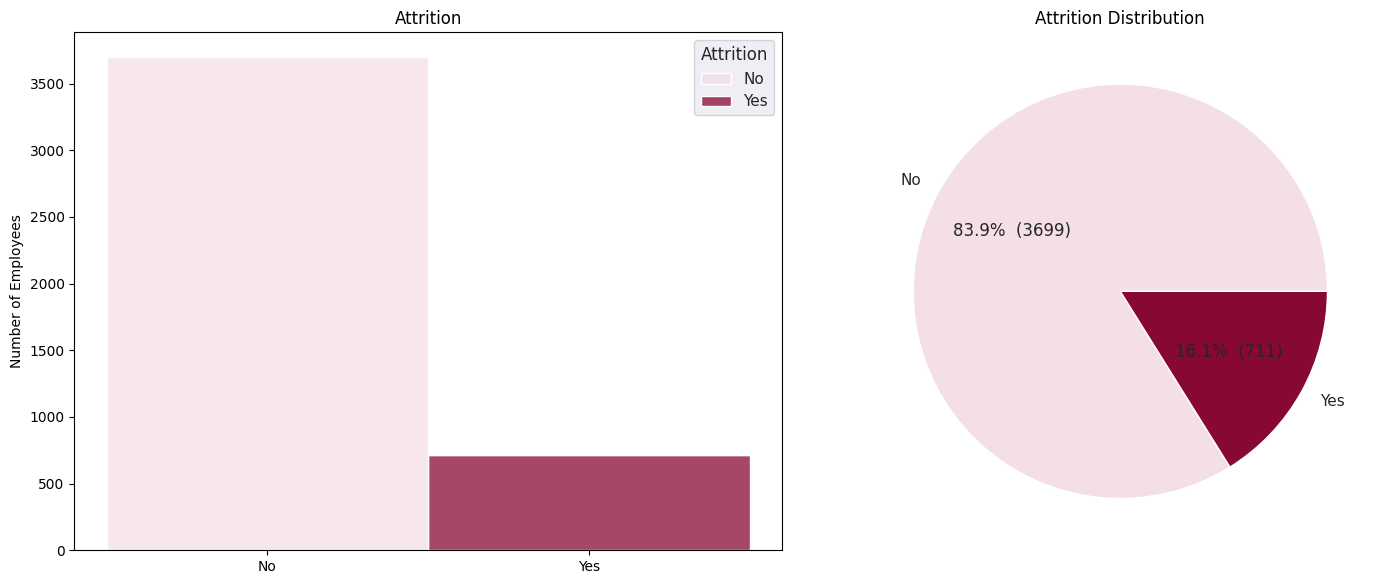

In [14]:
            ### Attrition ###

# Set plot size
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

sns.set(style="dark")

# Histogram for Attrition
my_palette = ['#f5dfe6', '#870931']
sns.histplot(data=df, x='Attrition', hue= 'Attrition', multiple='stack', palette=my_palette, ax=ax[0])
ax[0].set_title('Attrition')
ax[0].set_xlabel('')
ax[0].set_ylabel('Number of Employees')


# Pie Chart for Attrition
ax[1].set_title('Attrition Distribution')
attrition_counts = df['Attrition'].value_counts()
attrition_counts.plot(kind='pie', autopct=lambda p: '{:.1f}%  ({:.0f})'.format(p, p * sum(attrition_counts) / 100), colors=my_palette, ax=ax[1])
ax[1].set_ylabel('')

plt.tight_layout()
plt.show()

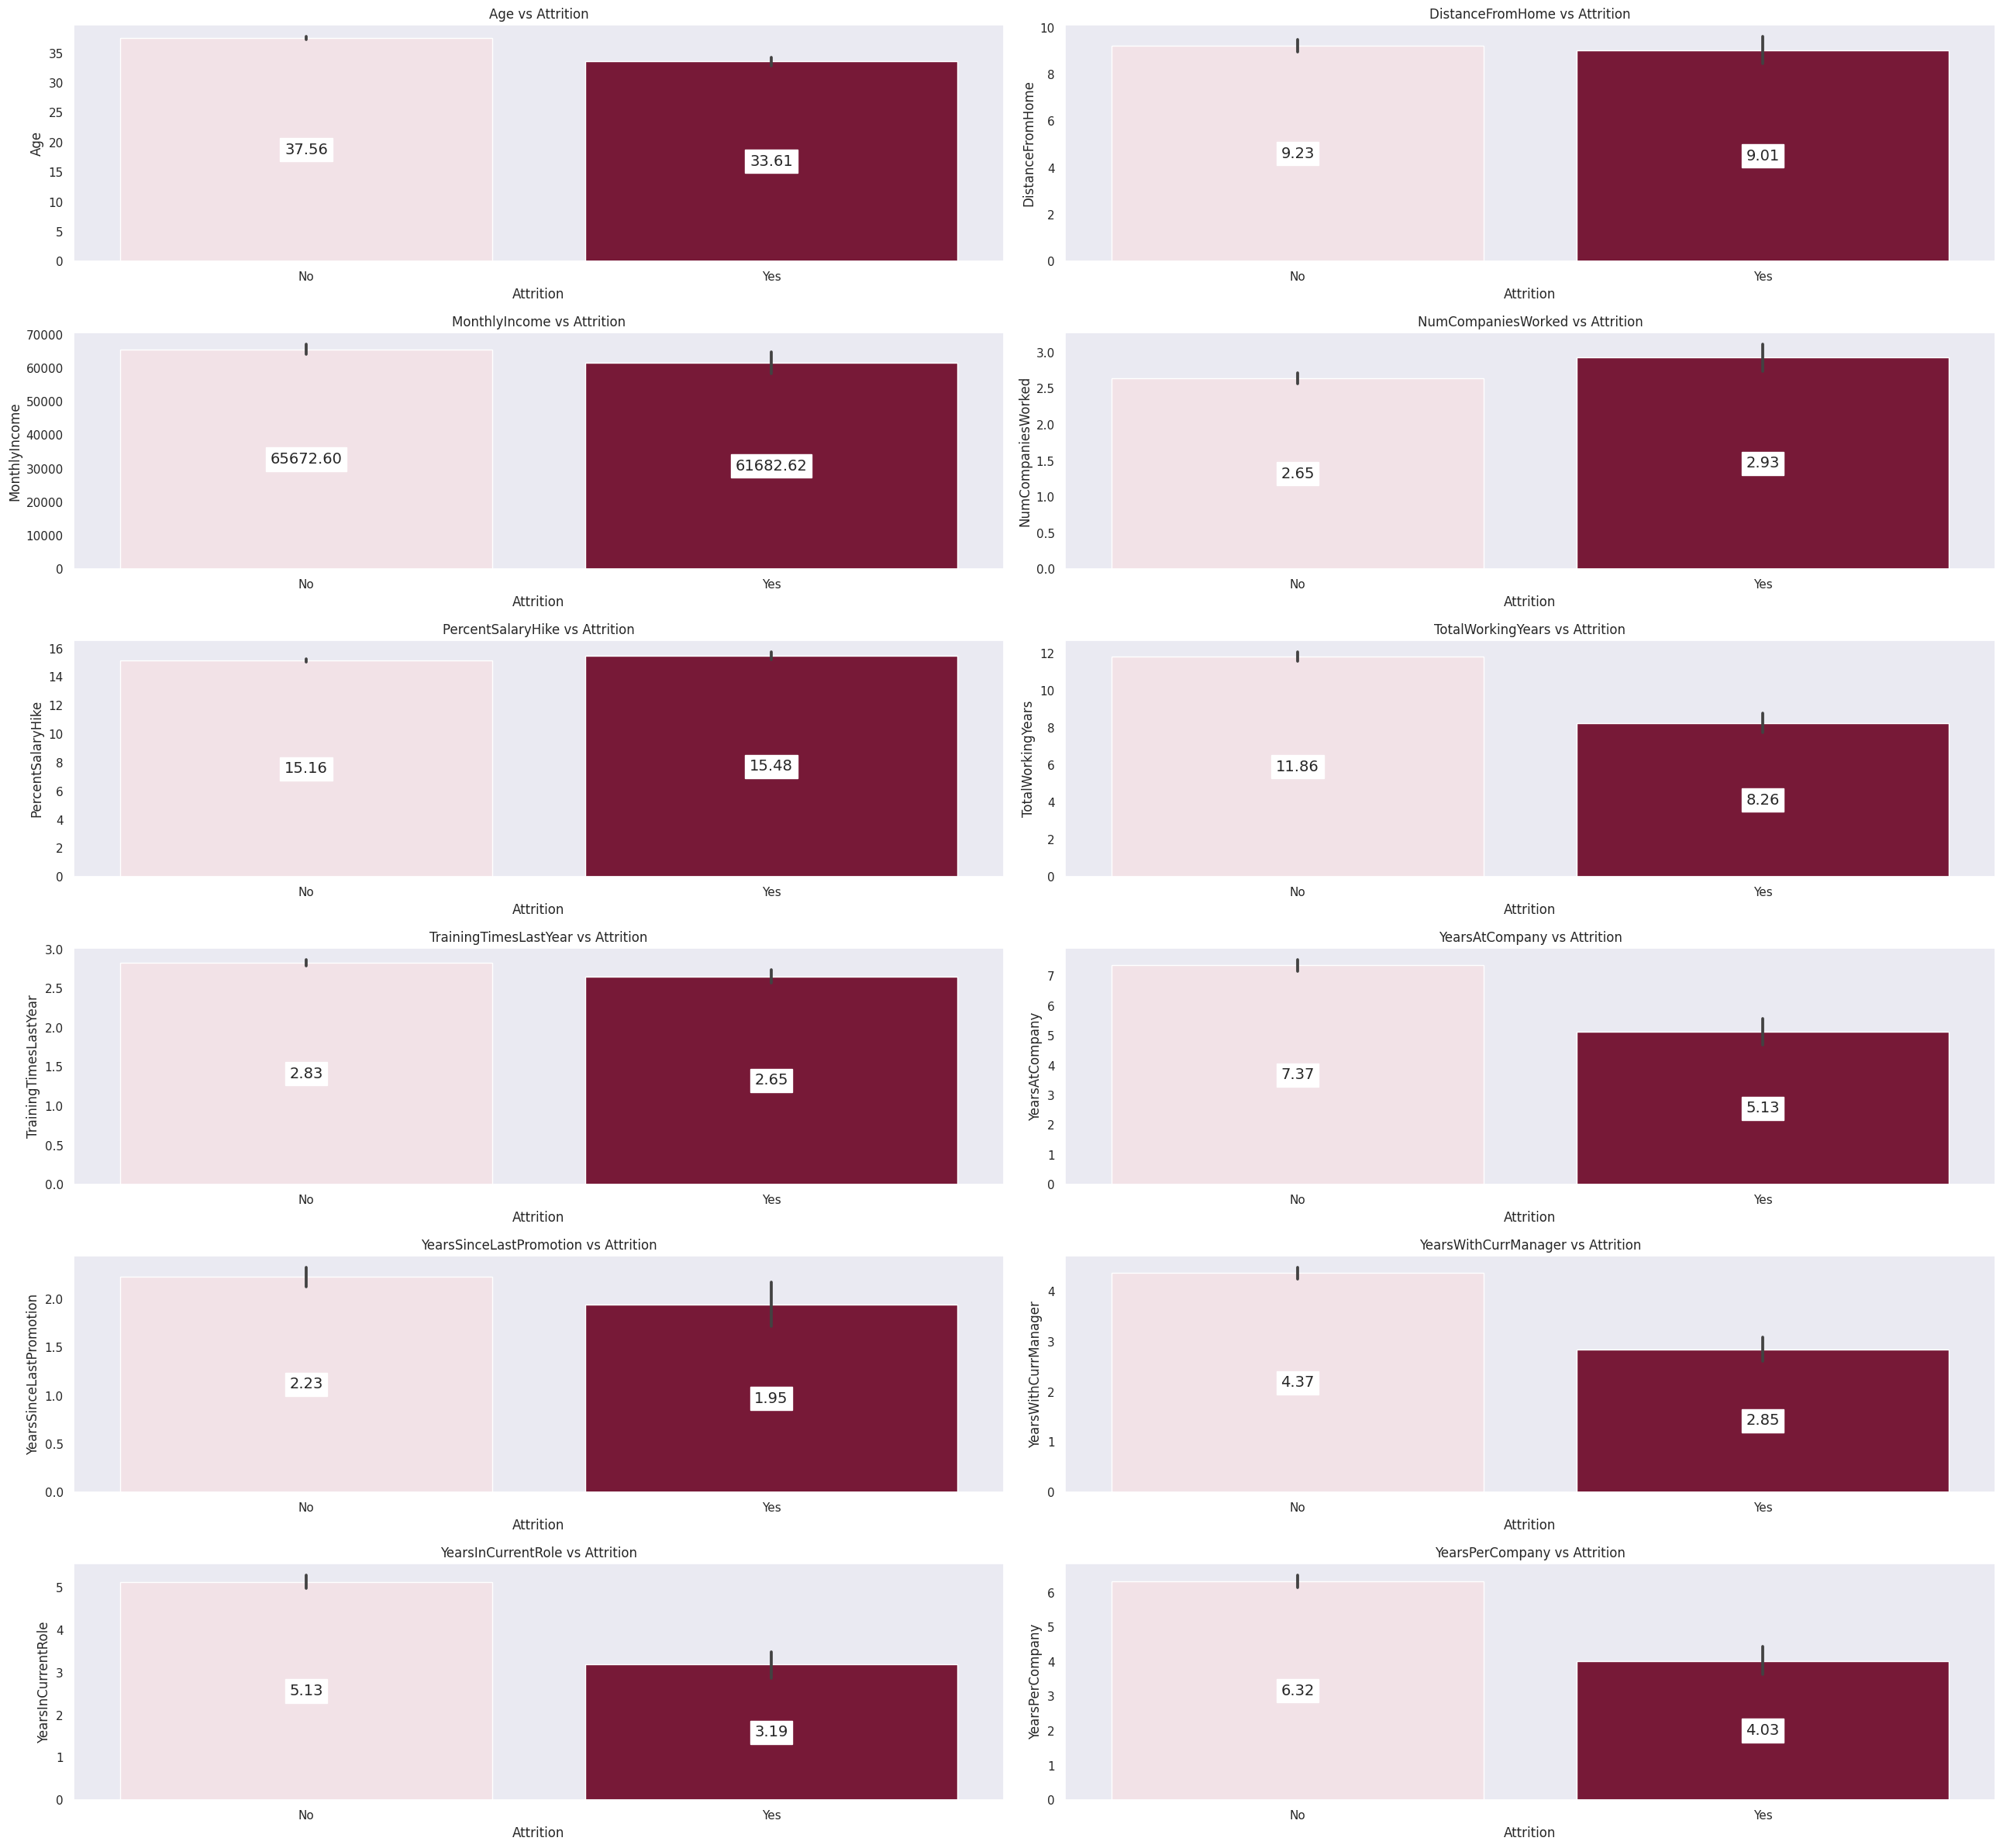

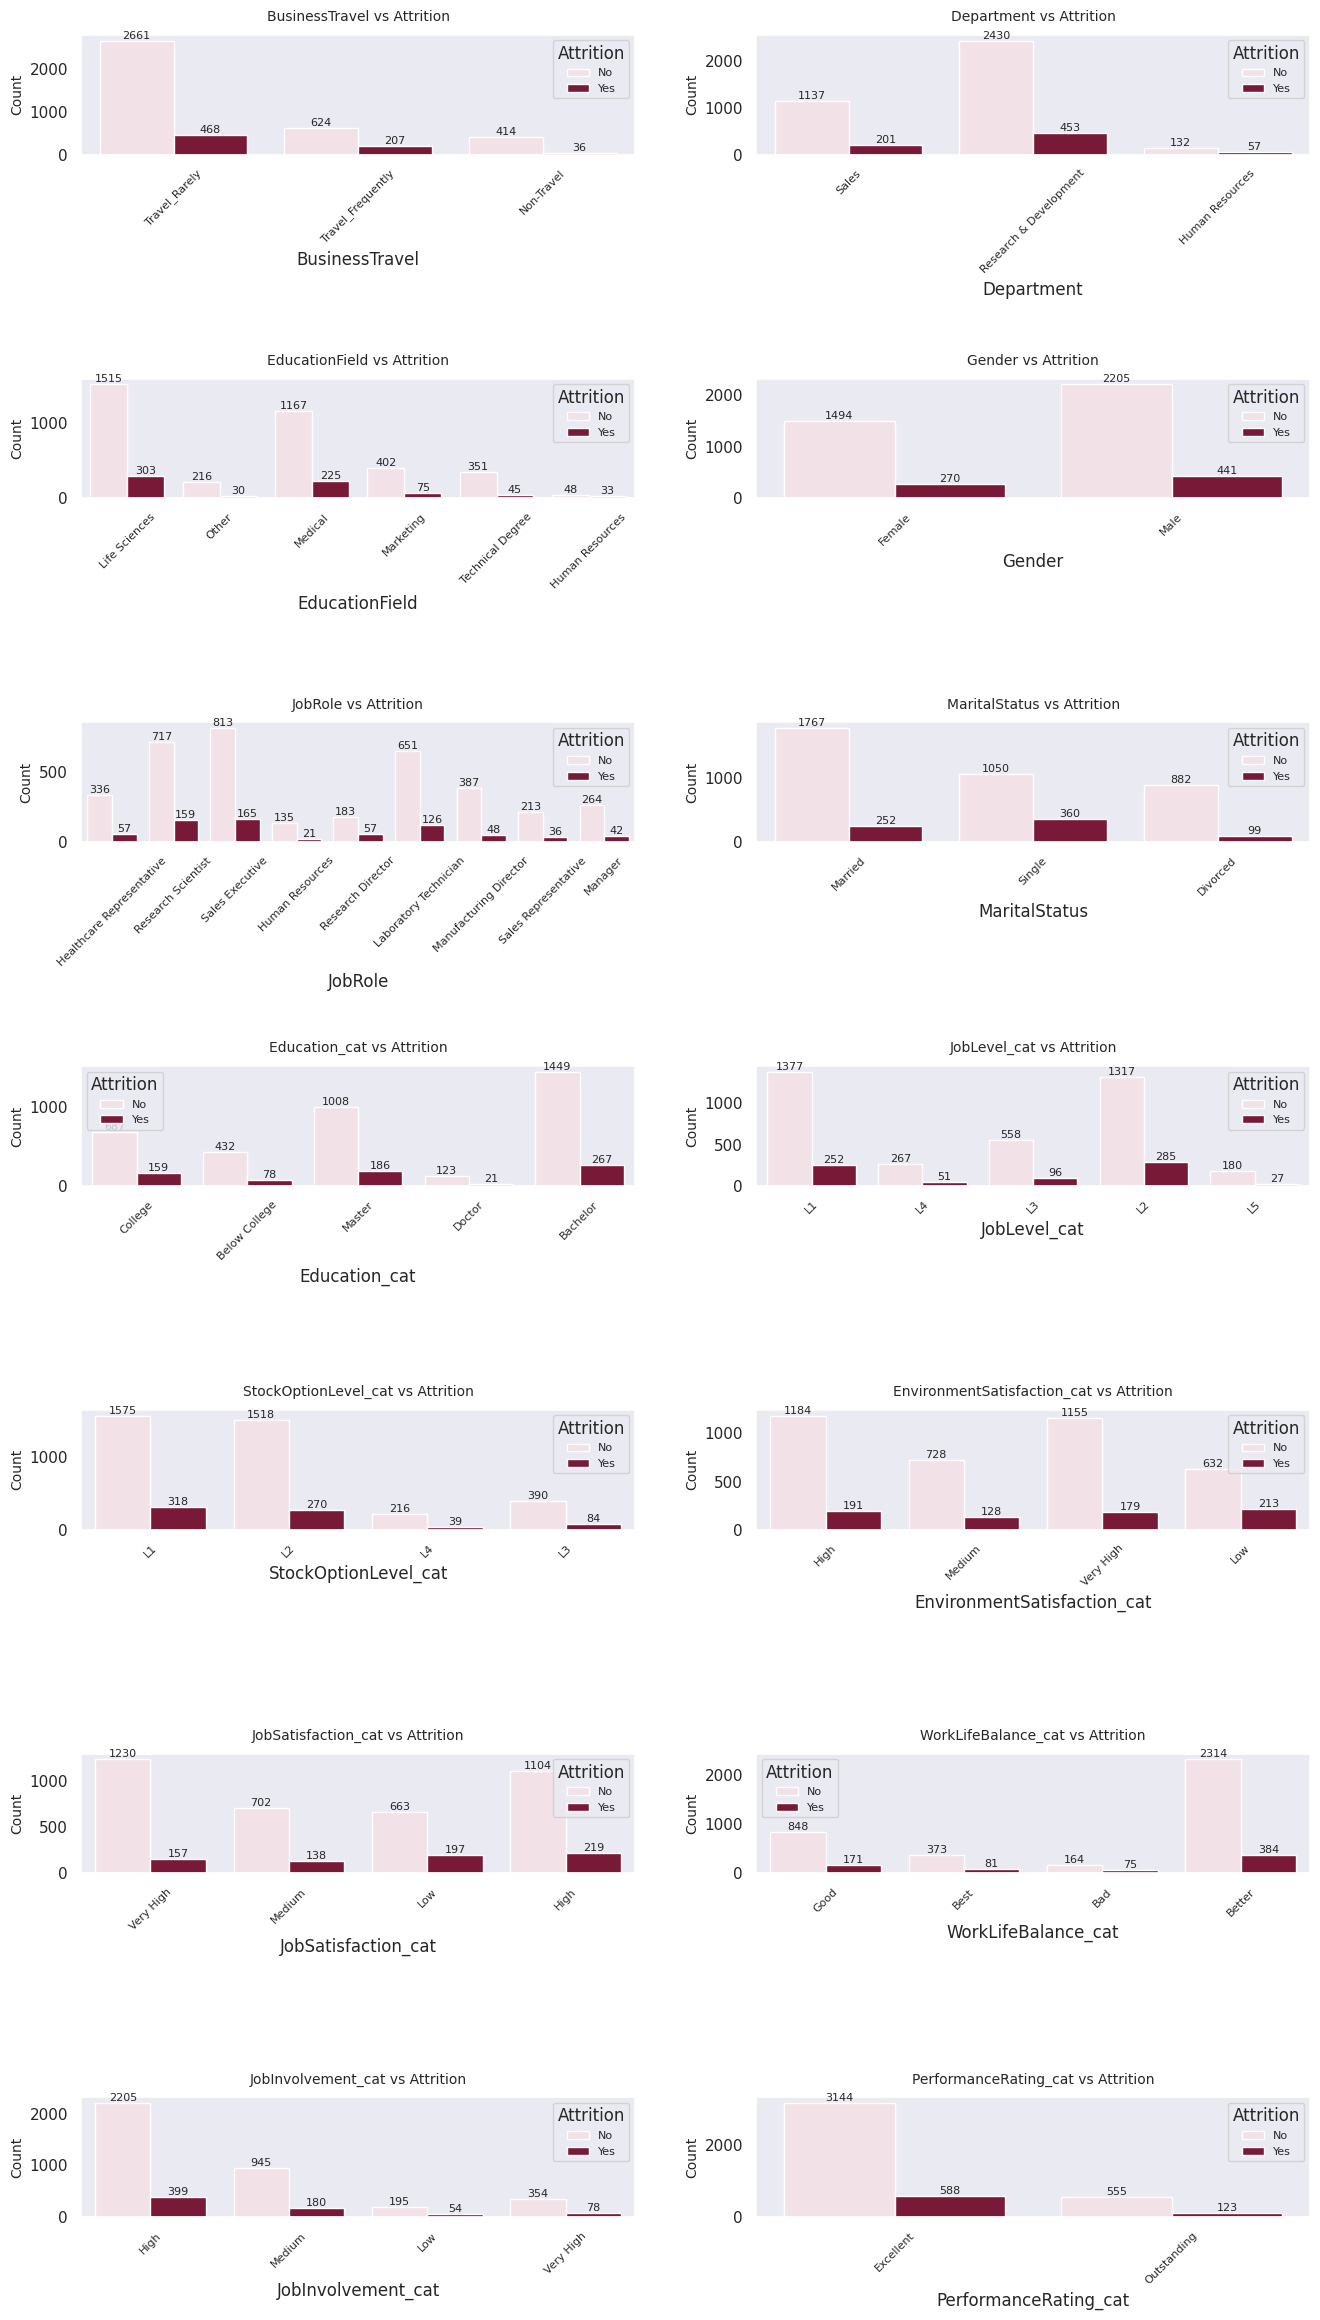

In [15]:
# Define custom colors for "No" and "Yes" categories
custom_colors = {'No': '#f5dfe6', 'Yes': '#870931'}
sns.set(style="dark")

# Plot numerical variables
fig, axes = plt.subplots(6, 2, figsize=(26, 24))
axes = axes.flatten()

for i, column in enumerate(num_variables):
    ax = axes[i]
    sns.barplot(data=df, x="Attrition", y=column, ax=ax, estimator=np.mean, palette=custom_colors)
    ax.set_title(f"{column} vs Attrition", fontsize=12)

    for k in ax.containers:
        ax.bar_label(
            k, fontsize=14, label_type="center", backgroundcolor="w", fmt="%.2f"
        )
plt.tight_layout()
plt.show()

# Plot categorical variables
fig, axes = plt.subplots(7, 2, figsize=(14, 24))
axes = axes.flatten()

for i, column in enumerate(cat_variables):
    ax = axes[i]
    sns.countplot(data=df, x=column, hue='Attrition', ax=ax, palette=custom_colors)
    ax.set_title(f"{column} vs Attrition", fontsize=10, pad=10) 
    ax.set_xlabel(column, fontsize=12)  
    ax.set_ylabel("Count", fontsize=10)  
    ax.legend(title='Attrition', fontsize=8)  
    ax.tick_params(axis='x', rotation=45, labelsize=8) 
    for container in ax.containers:
        ax.bar_label(container, fontsize=8)


plt.tight_layout(pad=3) 
plt.show()


<div style="border-radius:10px; border:#8EACCD solid; padding: 15px; background-color: #D2E0FB; font-size:100%; text-align:left">
    <h3 align="left"><font color='#A367B1'>💡 Insights</font></h3>

<ol style="color: #365486;">
    <li><b>Age</b></li>
        <ul style="color: #365486;">
        <li>For employees who have not left ('Attrition' = 'No'), the average age is approximately 37.58 years.</li>
        <li>For employees who have left ('Attrition'= 'Yes'), the average age is significantly lower, at around 33.61 years.</li>
        <li>This suggests that <b>younger employees are more likely to leave the organization</b>.</li>
        </ul>
    <li><b>Total Working Years</b></li>
        <ul style="color: #365486;">
        <li>For employees who have not left ('Attrition' = 'No'), the average number of years is approximately 11.86 years.</li>
        <li>For employees who have left ('Attrition' = 'Yes'), the average number of years is 8.26 </li>
        <li>This suggests that <b>employees with fewer years of overall work experience are more likely to leave the organization</b>.</li>
        </ul>
    <li><b>Years Current Role</b></li>
        <ul style="color: #365486;">
        <li>For employees who have not left ('Attrition' = 'No'), the average years in the current role is 5.13 years.</li>
        <li>For employees who have left ('Attrition' = 'Yes'), the average years in the current role is significantly lower, at 3.18 years.</li>
        <li>This indicates that <b>employees who leave the organization tend to have spent less time in their current positions</b>.</li>
        </ul>
     <li><b>Years Current Manager</b></li>
        <ul style="color: #365486;">
        <li>For employees who have not left ('Attrition' = 'No'), the average years with the current manager is 4.37.</li>
        <li>For employees who have left ('Attrition' = 'Yes'), the average years with the current manager is significantly lower, at 2.85.</li>
        <li>This suggests that <b>employees who leave the organization tend to have had shorter tenures with their current managers</b>.</li> </ul> 
     <li><b>Years per Company</b></li>
        <ul style="color: #365486;">
        <li>For employees who have not left ('Attrition' = 'No'), the average period of tenure is 6.32 years.</li>
        <li>For employees who have left ('Attrition' = 'Yes'), the average period of tenure is significantly lower, at 4.03 years.</li>
        <li>This suggests that <b>employees who leave the organization tend to have shorter tenures overall</b>.</li> 
        </ul>
     <li><b>Years at Company</b></li>
        <ul style="color: #365486;">
        <li>For employees who have not left ('Attrition' = 'No'), the average years period of tenure in the organization is 7.37.</li>
        <li>For employees who have left ('Attrition' = 'Yes'), the average years in the current role is significantly lower, at 5.13.</li>
        <li>This indicates that <b>employees who leave the organization tend to have shorter tenures with the company.</b>.</li> 
        </ul>
      <li><b>Marital Status</b></li>
        <ul style="color: #365486;">
        <li>Married: 2019 employees ('Attrition' = 'No': 1767(87.5%), 'Attrition' = 'Yes': 252(12.5%))</li>
        <li>Single: 1410 employees ('Attrition' = 'No': 1050(74.5%), 'Attrition' = 'Yes': 360(25.5%))</li>
        <li>Divorced: 981 employees ('Attrition' = 'No': 882(89.9%), 'Attrition' = 'Yes': 99(10.1%))</li> 
        <li>This suggests that <b>divorced employees are less likely to depart compared to single employees but slightly more likely compared to married ones</b>.</li>
        </ul>
      <li><b>Gender</b></li>
        <ul style="color: #365486;">
        <li>Male: 2624 employees ('Attrition' = 'No': 2205(84%), 'Attrition' = 'Yes': 441(16%))</li>
        <li>Female: 1764 employees ('Attrition' = 'No': 1494(84.7%), 'Attrition' = 'Yes': 270(15.3%))</li>
        <li>While there are slight differences in attrition rates between male and female employees, these differences are relatively small. </li>
        </ul>
       <li><b>Business Travel</b></li>
        <ul style="color: #365486;">
        <li>Non-Travel: 450 employees ('Attrition' = 'No': 414(92%), 'Attrition' = 'Yes': 36(8%))</li> 
        <li>Rarely: 3129 employees ('Attrition' = 'No': 2661(85%), 'Attrition' = 'Yes': 468(25%))</li>
        <li>Frequently: 831 employees ('Attrition' = 'No': 624(75.1%), 'Attrition' = 'Yes': 207(24.9%))</li>
        </ul>       
       <li><b>Job Satisfaction</b></li>
        <ul style="color: #365486;">
        <li>Low: 860 employees ('Attrition' = 'No': 663(77.1%), 'Attrition' = 'Yes': 197(22.9%))</li> 
        <li>Medium: 840 employees ('Attrition' = 'No': 702(83.6%), 'Attrition' = 'Yes': 138(16.4%))</li>
        <li>High: 1323 employees ('Attrition' = 'No': 1104(83.4%), 'Attrition' = 'Yes': 219(16.6%))</li>
        <li>Very High: 1387 employees ('Attrition' = 'No': 1230(88.7%), 'Attrition' = 'Yes': 157(11.3%))</li>
        </ul> 
       <li><b>Environment Satisfaction</b></li>
        <ul style="color: #365486;">
        <li>Low: 845 employees ('Attrition' = 'No': 632(74.8%), 'Attrition' = 'Yes': 213(25.2%))</li> 
        <li>Medium: 856 employees ('Attrition' = 'No': 728(85%), 'Attrition' = 'Yes': 128(15%))</li>
        <li>High: 1375 employees ('Attrition' = 'No': 1184(86.1%), 'Attrition' = 'Yes': 191(13.9%))</li>
        <li>Very High: 1334 employees ('Attrition' = 'No': 1155(86.6%), 'Attrition' = 'Yes': 179(13.4%))</li>
        </ul> 
       <li><b>Performance Rating</b></li>
        <ul style="color: #365486;">
        <li>Excellent: 3732 employees ('Attrition' = 'No': 3144(84.2%), 'Attrition' = 'Yes': 588(15.8%))</li> 
        <li>Outstanding: 678 employees ('Attrition' = 'No': 555(81.9%), 'Attrition' = 'Yes': 123(18.1%))</li>
        </ul>             
  </ol>

In [16]:
col_drop = ['Education_cat', 'JobLevel_cat', 'StockOptionLevel_cat', 
            'EnvironmentSatisfaction_cat', 'JobSatisfaction_cat', 'WorkLifeBalance_cat', 
            'JobInvolvement_cat', 'PerformanceRating_cat']
for i in col_drop:
    df.drop(i, axis=1, inplace=True)

<a id="7"></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#82A0D8;font-family:newtimeroman;color:white;font-size:160%;text-align:center;border-radius:10px 10px;">Encoding</p>

In [17]:
# Encode 'Attrition'
df['Attrition'] = df['Attrition'].apply(lambda x: 1 if x== 'Yes' else 0)

# Encode 'BusinessTravel'
df['BusinessTravel'] = df['BusinessTravel'].apply(lambda x: 0 if x == 'Non-Travel' else (1 if x == 'Travel_Rarely' else 2))

# Encode 'Department'
df['Department'] = df['Department'].apply(lambda x: 0 if x == 'Sales' else (1 if x == 'Research & Development' else 2))

# Encode 'EducationField'
df['EducationField'] = df['EducationField'].apply(lambda x: 0 if x == 'Life Sciences' else (1 if x == 'Other' else (2 if x == 'Medical' else (3 if x == 'Marketing' else (4 if x == 'Technical Degree' else 5)))))

# Encode 'Gender'
df['Gender'] = df['Gender'].apply(lambda x: 0 if x == 'Female' else 1)

# Encode 'JobRole'
df['JobRole'] = df['JobRole'].apply(lambda x: 0 if x == 'Healthcare Representative' else (1 if x == 'Research Scientist' else (2 if x == 'Sales Executive' else (3 if x == 'Human Resources' else (4 if x == 'Research Director' else (5 if x == 'Laboratory Technician' else (6 if x == 'Manufacturing Director' else (7 if x == 'Sales Representative' else 8))))))))

# Encode 'MaritalStatus'
df['MaritalStatus'] = df['MaritalStatus'].apply(lambda x: 0 if x == 'Single' else (1 if x == 'Married' else 2))

In [18]:
# check_unique_values(df, df.columns)

# Change data type
df['NumCompaniesWorked'] = df['NumCompaniesWorked'].astype(int) 
df['TotalWorkingYears'] = df['TotalWorkingYears'].astype(int)
df['EnvironmentSatisfaction'] = df['EnvironmentSatisfaction'].astype(int)
df['JobSatisfaction'] = df['JobSatisfaction'].astype(int)
df['WorkLifeBalance'] = df['WorkLifeBalance'].astype(int)

check_unique_values(df, df.columns)

Age: [51 31 32 38 46 28 29 25 45 36 55 47 37 21 35 26 50 53 42 44 49 18 41 39
 58 33 43 52 27 30 54 40 23 48 57 34 24 22 56 60 19 20 59]

Attrition: [0 1]

BusinessTravel: [1 2 0]

Department: [0 1 2]

DistanceFromHome: [ 6 10 17  2  8 11 18  1  7 28 14  3  4 16  9  5 20 29 15 13 24 19 22 25
 21 26 27 12 23]

Education: [2 1 4 5 3]

EducationField: [0 1 2 3 4 5]

Gender: [0 1]

JobLevel: [1 4 3 2 5]

JobRole: [0 1 2 3 4 5 6 7 8]

MaritalStatus: [1 0 2]

MonthlyIncome: [131160  41890 193280 ...  37020  23980  54680]

NumCompaniesWorked: [1 0 3 4 2 7 9 5 6 8]

PercentSalaryHike: [11 23 15 12 13 20 22 21 17 14 16 18 19 24 25]

StockOptionLevel: [0 1 3 2]

TotalWorkingYears: [ 1  6  5 13  9 28 10 21 16 37  7  3 15  8 12 17 19 22  2  4 23  0 11 24
 25 20 14 26 18 30 36 31 33 32 34 40 29 35 27 38]

TrainingTimesLastYear: [6 3 2 5 4 0 1]

YearsAtCompany: [ 1  5  8  6  7  0  9 20 15 36 10  3 17  2  4 11 22 18 13 24 21 16 25 29
 27 14 31 32 34 26 12 19 33 30 23 37 40]

YearsSinceLastPromotion: 

<a id="8"></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#82A0D8;font-family:newtimeroman;color:white;font-size:160%;text-align:center;border-radius:10px 10px;">Correlation Analysis</p>

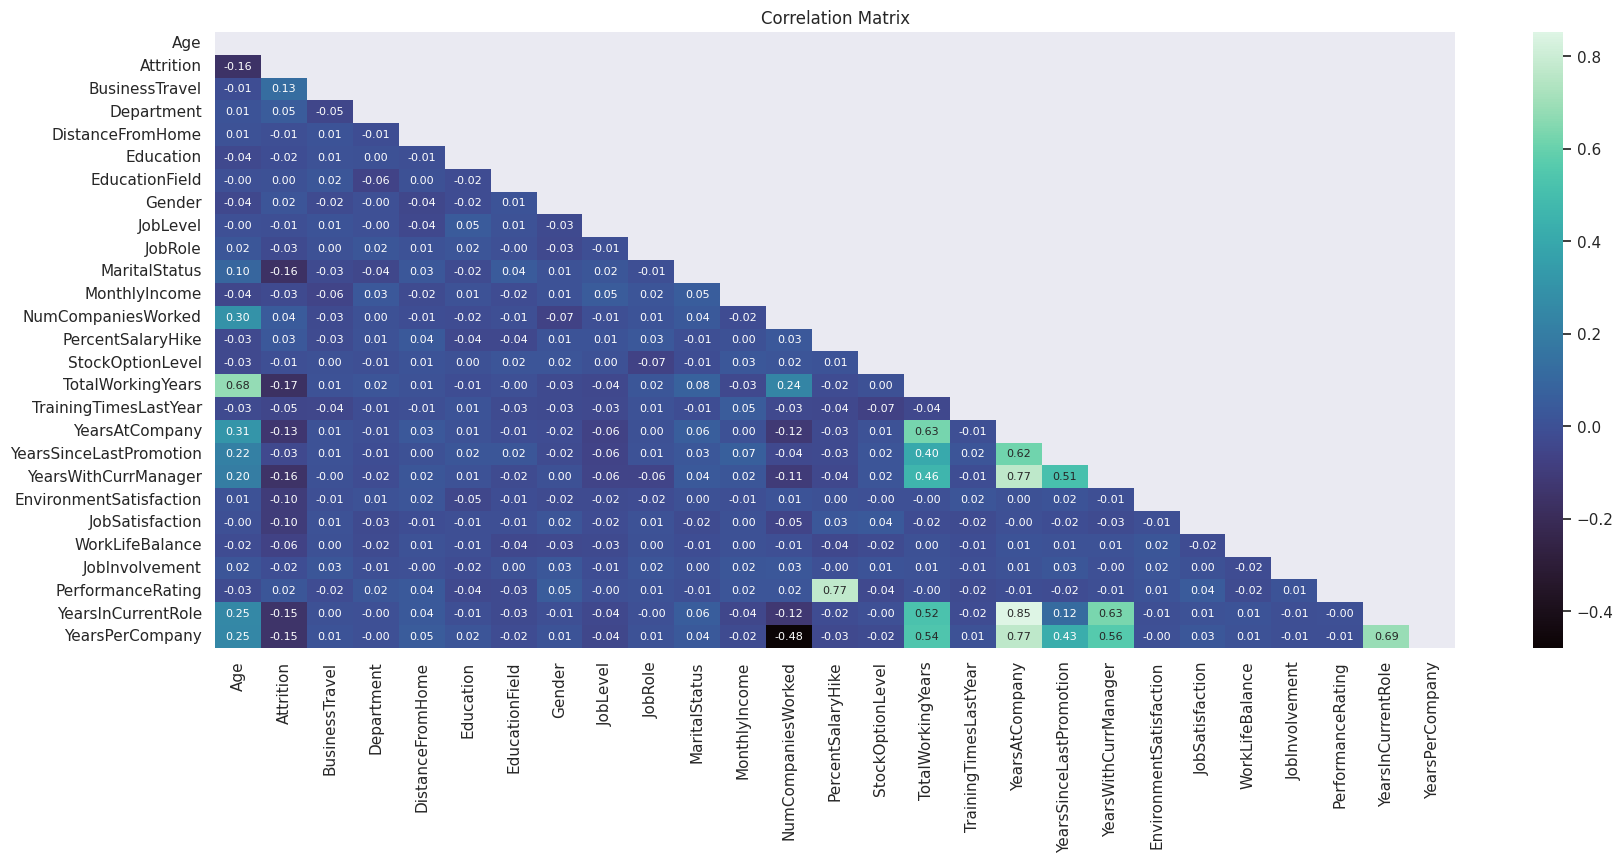

In [19]:
# Correlation Matrix
plot_correlation_matrix(df)


<div style="border-radius:10px; border:#8EACCD solid; padding: 15px; background-color: #D2E0FB; font-size:100%; text-align:left">
    <h3 align="left"><font color='#A367B1'>💡 Crorrelation Matrix Insights</font></h3>

<ul style="color: #365486;">
  <li><b>TotalWorkingYears:</b> There is a moderate negative correlation (<b>-0.170</b>) between total working years and attrition, implying that <i>employees with fewer years of service</i> are more likely to leave.</li>
  <br>
  <li><b>Age:</b> There is a moderate negative correlation (<b>-0.159</b>) between age and attrition, indicating that <i>younger employees</i> are more likely to leave the company.</li>
  <br>
  <li><b>YearsWithCurrManager:</b> There is a moderate negative correlation (<b>-0.156</b>) between the number of years with the current manager and attrition, indicating that <i>employees with shorter tenure under their current manager</i> are more likely to leave.</li>
  <br>
  <li><b>YearsAtCompany:</b> There is a moderate negative correlation (<b>-0.134</b>) between the number of years at the company and attrition, suggesting that <i>employees who have been with the company for fewer years</i> are more likely to leave.</li>
  <br>
  <li><b>Job Satisfaction</b>: There's a moderate negative correlation (<b>-0.104</b>) between job satisfaction and attrition. This is an important insight, indicating that <i>employees who are less satisfied with their jobs</i> are more likely to leave.</li>
  <br>
  <li><b>YearsSinceLastPromotion:</b> There is a slight negative correlation (<b>-0.033</b>) between the number of years since the last promotion and attrition, implying that <i>employees who have not been promoted recently</i> are slightly more likely to leave.</li>
  <br>
  <li><b>MonthlyIncome:</b> There is a slight negative correlation (<b>-0.031</b>) between monthly income and attrition, suggesting that <i>lower-paid employees</i> may be more likely to leave.</li>
  <br>
  <li><b>NumCompaniesWorked:</b> There is a slight positive correlation (<b>0.042</b>) between the number of companies worked for and attrition, indicating that <i>employees who have worked for more companies</i> are slightly more likely to leave.</li>
  <br>
  <li><b>Business Travel</b>: There is a moderate positive correlation between business travel and attrition (<b>0.127</b>), indicating that <i>employees who travel more frequently for business purposes</i> may have a slightly higher tendency to leave the company compared to those who travel less or not at all.</li>
  <br>




</ul>

<a id="9"></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#82A0D8;font-family:newtimeroman;color:white;font-size:160%;text-align:center;border-radius:10px 10px;">Data Preprocessing</p>

In [20]:
# Define feature variables (X) and target variable (y)
X = df.drop('Attrition', axis=1) 
y = df['Attrition']

# Standardize data
scaler = StandardScaler()
X = scaler.fit_transform(X)
'''
After standardization, each feature will have a mean of 0 and a standard deviation of 1, 
which helps algorithms converge faster and makes comparisons between features more meaningful.

It's important to note that standardization does NOT change the shape of the distribution of the data, only its scale.
'''

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print shapes of the feature matrix and target vector in training and testing sets
print("Shape of feature matrices:", X_train.shape, X_test.shape)
print("Shape of target variable:", y_train.shape, y_test.shape)

# Plot the distribution of classes in training target vector
# visualize_class_imbalance(y_train)

Shape of feature matrices: (3528, 26) (882, 26)
Shape of target variable: (3528,) (882,)


In [21]:
# SMOTE (Synthetic Minority Over-sampling Technique)
'''
It generates synthetic samples for the minority class by interpolating between existing instances. T
he resulting X_resampled and y_resampled arrays contain the oversampled data, 
where the minority class is balanced with the majority class.
'''

# Calculate class distribution before SMOTE
class_distribution_before = Counter(y_train)

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Perform SMOTE oversampling
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Calculate class distribution after SMOTE
class_distribution_after = Counter(y_resampled)

# Print information about the final dataset after SMOTE oversampling
print("Shape of feature matrix (X_resampled):", X_resampled.shape)
print("Shape of target variable (y_resampled):", y_resampled.shape)

# Calculate percentages
total_samples = len(y_resampled)
percentages_after_smote = {cls: count / total_samples * 100 for cls, count in class_distribution_after.items()}

# Print percentages
print("\nClass Distribution Before SMOTE:")
for cls, count in class_distribution_before.items():
    print(f"Class {cls}: {count} samples")

print("\nClass Distribution After SMOTE:")
for cls, count in class_distribution_after.items():
    print(f"Class {cls}: {count} samples ({percentages_after_smote[cls]:.2f}% of total)")


# visualize_class_imbalance(y_resampled)


Shape of feature matrix (X_resampled): (5916, 26)
Shape of target variable (y_resampled): (5916,)

Class Distribution Before SMOTE:
Class 0: 2958 samples
Class 1: 570 samples

Class Distribution After SMOTE:
Class 0: 2958 samples (50.00% of total)
Class 1: 2958 samples (50.00% of total)


<a id="10"></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#82A0D8;font-family:newtimeroman;color:white;font-size:160%;text-align:center;border-radius:10px 10px;">Classification Models</p>

In [22]:
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Support Vector Classifier": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest Classifier": RandomForestClassifier(),
    "XGBoost Classifier": XGBClassifier(),
    "Extra Trees Classifier": ExtraTreesClassifier(),
    "AdaBoost Classifier": AdaBoostClassifier(),
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
    "Bagging Classifier": BaggingClassifier(),
    "Histogram-based Gradient Boosting Classifier": HistGradientBoostingClassifier(),
    "Gaussian Naive Bayes": GaussianNB(),
    "Multi-layer Perceptron": MLPClassifier(),
}

In [23]:
### Cross Validation ###

# Initialize lists to store metrics
classifier_names = []
accuracies = []
precisions = []
recalls = []
f1_scores_list = []

# Iterate over classifiers
for classifier_name, classifier_instance in classifiers.items():
    clf = classifier_instance
    
    # Perform cross-validation
    cv_scores = cross_val_score(clf, X_resampled, y_resampled, cv=3, scoring='accuracy')
    
    # Additional evaluation metrics
    precision_scores = cross_val_score(clf, X_resampled, y_resampled, cv=3, scoring='precision')
    recall_scores = cross_val_score(clf, X_resampled, y_resampled, cv=3, scoring='recall')
    f1_scores = cross_val_score(clf, X_resampled, y_resampled, cv=3, scoring='f1')
    
    print(f"{classifier_name}:")
    print(f"  Accuracy: {cv_scores.mean():.2f} with a standard deviation of {cv_scores.std():.2f}")
    print(f"  Precision: {precision_scores.mean():.2f} with a standard deviation of {precision_scores.std():.2f}")
    print(f"  Recall: {recall_scores.mean():.2f} with a standard deviation of {recall_scores.std():.2f}")
    print(f"  F1 Score: {f1_scores.mean():.2f} with a standard deviation of {f1_scores.std():.2f}")
    print('-'*50)
    
    # Append metrics to lists
    classifier_names.append(classifier_name)
    accuracies.append(cv_scores.mean())
    precisions.append(precision_scores.mean())
    recalls.append(recall_scores.mean())
    f1_scores_list.append(f1_scores.mean())

# Create DataFrame
metrics_df = pd.DataFrame({
    'Classifier': classifier_names,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1 Score': f1_scores_list
})


Logistic Regression:
  Accuracy: 0.72 with a standard deviation of 0.02
  Precision: 0.71 with a standard deviation of 0.01
  Recall: 0.74 with a standard deviation of 0.02
  F1 Score: 0.73 with a standard deviation of 0.02
--------------------------------------------------
Support Vector Classifier:
  Accuracy: 0.95 with a standard deviation of 0.01
  Precision: 0.93 with a standard deviation of 0.01
  Recall: 0.98 with a standard deviation of 0.01
  F1 Score: 0.95 with a standard deviation of 0.01
--------------------------------------------------
K-Nearest Neighbors:
  Accuracy: 0.87 with a standard deviation of 0.01
  Precision: 0.80 with a standard deviation of 0.01
  Recall: 1.00 with a standard deviation of 0.00
  F1 Score: 0.89 with a standard deviation of 0.01
--------------------------------------------------
Decision Tree:
  Accuracy: 0.96 with a standard deviation of 0.01
  Precision: 0.96 with a standard deviation of 0.00
  Recall: 0.96 with a standard deviation of 0.03
  

In [24]:
metrics_df.round(4)

,Classifier,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.7214,0.7122,0.7431,0.7273
1,Support Vector Classifier,0.9517,0.9293,0.9777,0.9529
2,K-Nearest Neighbors,0.8734,0.7999,0.9963,0.8873
3,Decision Tree,0.9647,0.9648,0.9591,0.9627
4,Random Forest Classifier,0.9890,0.9938,0.9814,0.9878
5,XGBoost Classifier,0.9858,0.9904,0.9811,0.9856
6,Extra Trees Classifier,0.9941,0.9932,0.9943,0.9939
7,AdaBoost Classifier,0.8032,0.8189,0.7786,0.7945
8,Gradient Boosting Classifier,0.8976,0.9123,0.8800,0.8938
9,Bagging Classifier,0.9789,0.9872,0.9706,0.9753


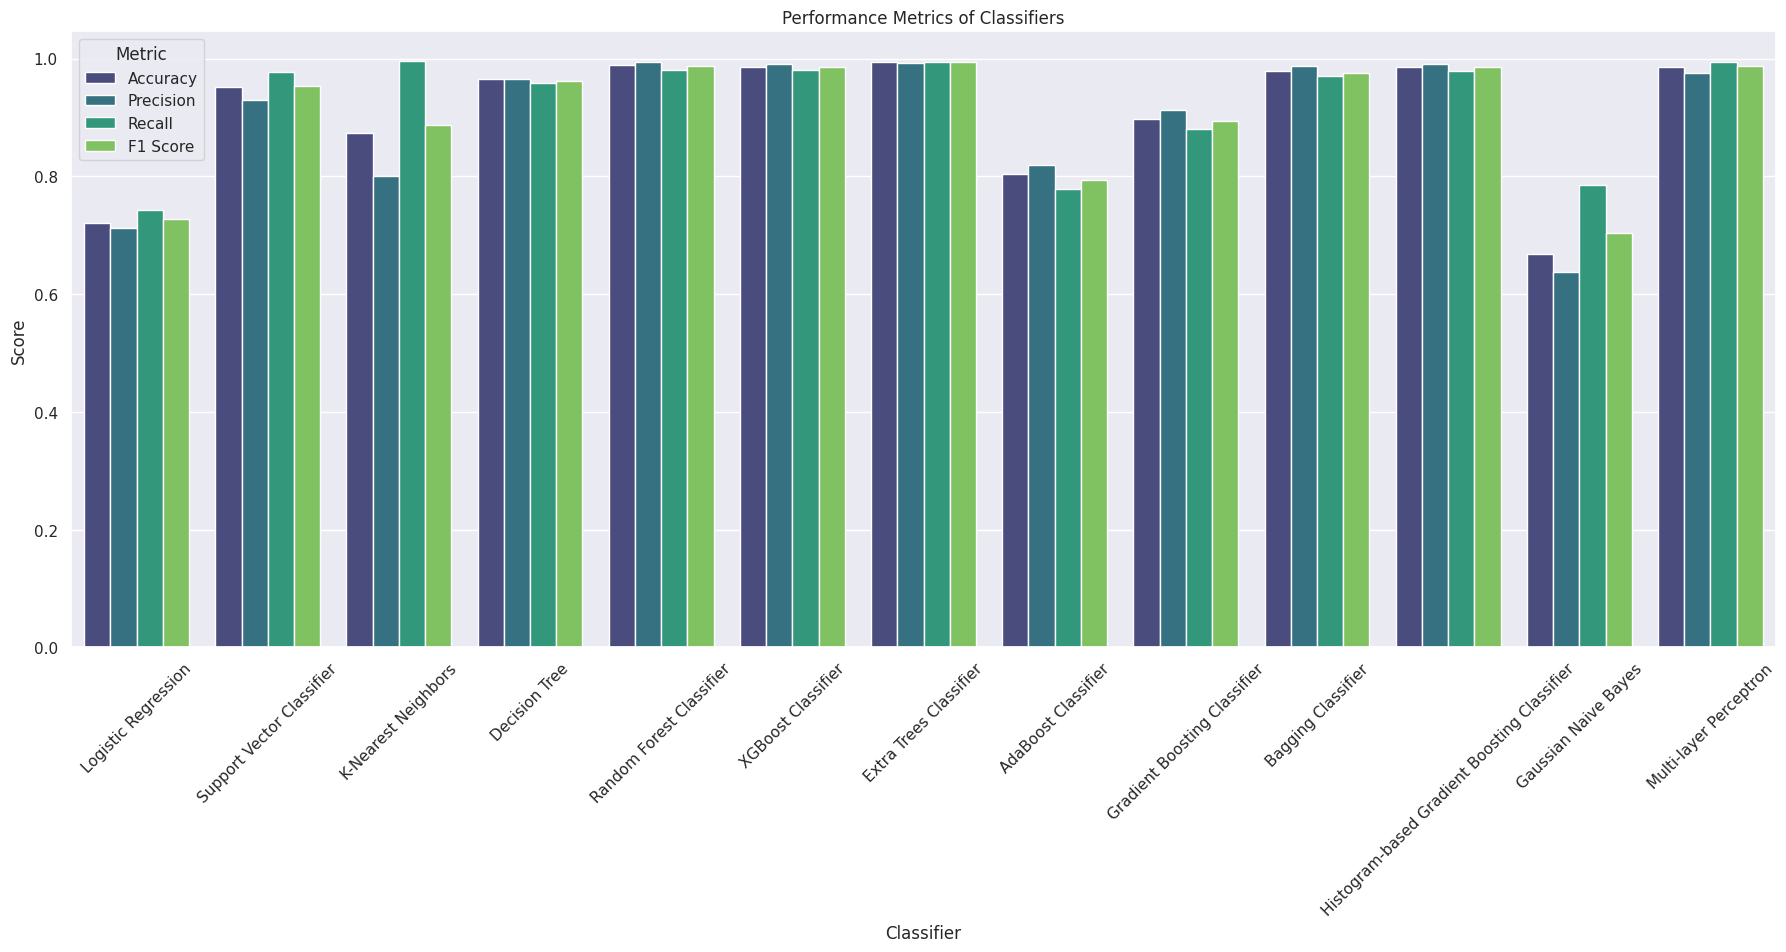

In [25]:
            ### Cross Validation Report ###

# Reshape the DataFrame into a long format
metrics_long_df = metrics_df.melt(id_vars='Classifier', var_name='Metric', value_name='Score')

# Set seaborn style
sns.set(style="darkgrid")

# Initialize the matplotlib figure
plt.figure(figsize=(22, 8))

# Plot metrics
sns.barplot(x='Classifier', y='Score', hue='Metric', data=metrics_long_df, palette='viridis')

# Add labels and title
plt.xlabel('Classifier')
plt.tick_params(axis='x', rotation=45)
plt.ylabel('Score')
plt.title('Performance Metrics of Classifiers')

# Add legend
plt.legend(title='Metric')

# Show plot
plt.show()


<div style="border-radius:10px; border:#8EACCD solid; padding: 15px; background-color: #D2E0FB; font-size:100%; text-align:left">
    <h3 align="left"><font color='#A367B1'>💡 Cross Validation Insights</font></h3>
<ol style="color: #365486;">
    <li><b>Logistic Regression:</b>shows moderate performance with an accuracy of 72.13%, precision of 71.21%, recall of 74.27% and F1 score of 72.71%. While it performs reasonably well, there is room for improvement, particularly in precision.</li>
    <br>
    <li><b>Support Vector Classifier:</b> demonstrates high accuracy of 95.17%, balanced precision of 92.93% and recall of 97.77%, resulting in an impressive F1 score of 95.29%. It effectively identifies both attrition cases and non-attrition cases.</li>
    <br>
    <li><b>K-Nearest Neighbors:</b> achieves high accuracy of 87.34% but exhibits lower precision of 79.99% compared to other models. However, it has almost perfect recall of 99.63%, indicating it captures almost all true attrition cases.</li>
    <br>
    <li><b>Decision Tree:</b> maintains b performance with an accuracy of 96.50%, balanced precision of 96.73% and recall  of 96.15%, resulting in an F1 score of 96.30%. It is a reliable and interpretable model.</li>
    <br>
    <li><b>Random Forest Classifier:</b> demonstrates near-perfect accuracy of 98.88% and high precision of 99.32% and recall of 98.17%, resulting in an F1 score of 98.85%. It is a robust model for predicting attrition.</li>
    <br>
    <li><b>XGBoost Classifier:</b> maintains excellent performance with an accuracy of 98.58%, precision of 99.04%, recall of 98.11%, and F1 score of 98.56%. It is a b performer among the ensemble methods.</li>
    <br>
     <li><b>Extra Trees Classifierr:</b> achieves almost perfect performance with an accuracy of 99.46%, precision of 99.69%, recall of 99.39% and F1 score of 99.42%. It provides reliable predictions with minimal overfitting.</li>
     <br>
    <li><b>AdaBoost Classifier:</b> shows moderate performance with an accuracy of 80.32%, precision of 81.89%, recall of 77.86% and F1 score of 79.45%. While it performs decently, there is room for improvement compared to other models.</li>
    <br>
    <li><b>Gradient Boosting Classifier:</b> maintains solid performance with an accuracy of 89.77%, precision of 91.23%, recall of 88.00% and F1 score of 89.38%. It continues to be a b performer among boosting algorithms.</li>
    <br>
    <li><b>Bagging Classifier:</b> achieves high accuracy of 98.04% and balanced precision of 99.01% and recall of 96.52%, resulting in an F1 score of 97.81%. It provides stable predictions with low variance.</li>
    <br>
    <li><b>Histogram-based Gradient Boosting Classifier:</b> maintains b performance with an accuracy of 98.53%, precision of 99.07%, recall of 97.97% and F1 score of 98.50%. It is a reliable option for classification tasks.</li>
    <br>
    <li><b>Gaussian Naive Bayes:</b> exhibits the lowest performance among the models, with an accuracy of 66.87%, precision of 63.71%, recall of 78.57%, and F1 score of 70.35%. It may not be the best choice for this task given its lower accuracy and precision.</li>
    <br><li><b>Multi-layer Perceptron:</b> achieves high accuracy of 98.43%, precision of 97.62%, recall of 99.53% and F1 score of 98.51%. It remains one of the top-performing classifiers, providing accurate predictions and effective identification of attrition cases.</li> 
</ol>


<p style="color: #365486;">In summary, models such as <b><i>Extra Trees Classifier</i></b>, <b><i>Random Forest Classifier</i></b> and <b><i>XGBoost Classifier</i></b> perform exceptionally well compared with the other ones, providing <u>accurate predictions</u> and maintaining a <u>balance between precision and recall</u>. These models are suitable for predicting employee attrition and identifying important features which is good news.</p>



-------------------- Logistic Regression --------------------
LogisticRegression Accuracy: 0.853

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.98      0.92       741
           1       0.63      0.19      0.29       141

    accuracy                           0.85       882
   macro avg       0.75      0.58      0.61       882
weighted avg       0.83      0.85      0.82       882


Confusion Matrix:
[[725  16]
 [114  27]]


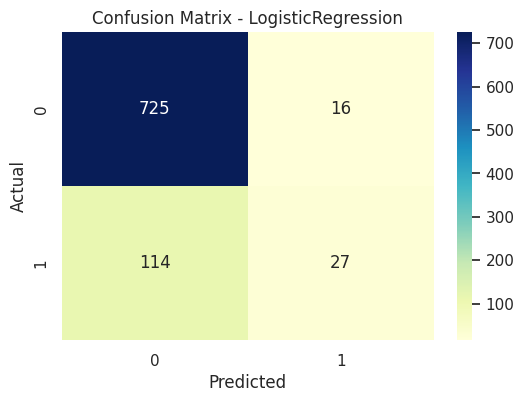

-------------------- Support Vector Classifier --------------------
SVC Accuracy: 0.918

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       741
           1       0.95      0.52      0.67       141

    accuracy                           0.92       882
   macro avg       0.93      0.76      0.81       882
weighted avg       0.92      0.92      0.91       882


Confusion Matrix:
[[737   4]
 [ 68  73]]


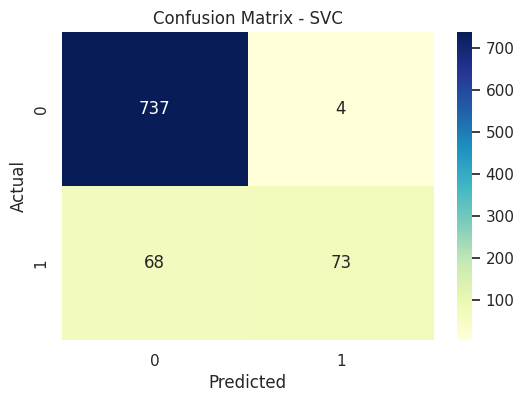

-------------------- K-Nearest Neighbors --------------------
KNeighborsClassifier Accuracy: 0.831

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.94      0.90       741
           1       0.45      0.28      0.34       141

    accuracy                           0.83       882
   macro avg       0.66      0.61      0.62       882
weighted avg       0.80      0.83      0.81       882


Confusion Matrix:
[[694  47]
 [102  39]]


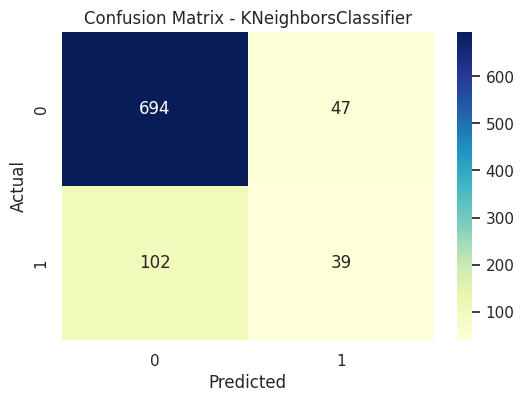

-------------------- Decision Tree --------------------
DecisionTreeClassifier Accuracy: 0.986

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       741
           1       0.96      0.96      0.96       141

    accuracy                           0.99       882
   macro avg       0.97      0.97      0.97       882
weighted avg       0.99      0.99      0.99       882


Confusion Matrix:
[[735   6]
 [  6 135]]


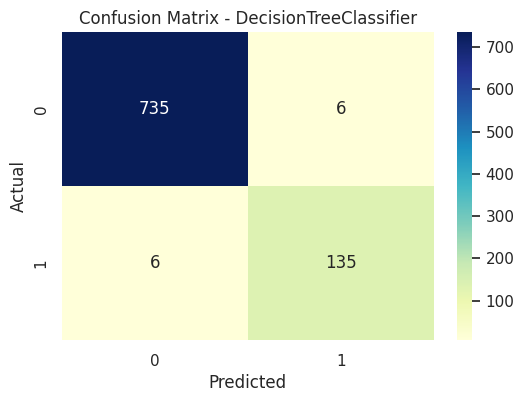

-------------------- Random Forest Classifier --------------------
RandomForestClassifier Accuracy: 0.992

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       741
           1       1.00      0.95      0.97       141

    accuracy                           0.99       882
   macro avg       1.00      0.98      0.98       882
weighted avg       0.99      0.99      0.99       882


Confusion Matrix:
[[741   0]
 [  7 134]]


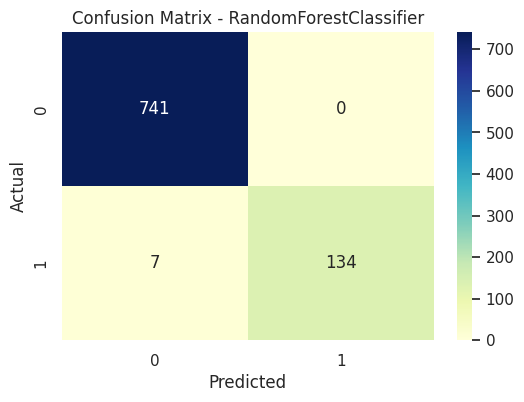

-------------------- XGBoost Classifier --------------------
XGBClassifier Accuracy: 0.993

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       741
           1       0.98      0.98      0.98       141

    accuracy                           0.99       882
   macro avg       0.99      0.99      0.99       882
weighted avg       0.99      0.99      0.99       882


Confusion Matrix:
[[738   3]
 [  3 138]]


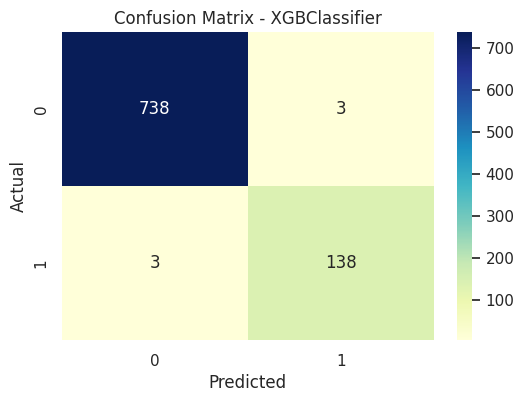

-------------------- Extra Trees Classifier --------------------
ExtraTreesClassifier Accuracy: 0.993

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       741
           1       1.00      0.96      0.98       141

    accuracy                           0.99       882
   macro avg       1.00      0.98      0.99       882
weighted avg       0.99      0.99      0.99       882


Confusion Matrix:
[[741   0]
 [  6 135]]


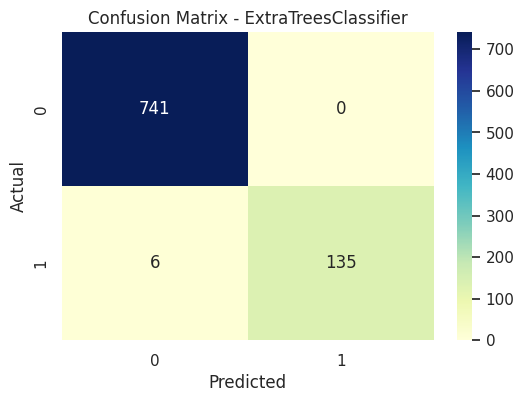

-------------------- AdaBoost Classifier --------------------
AdaBoostClassifier Accuracy: 0.854

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       741
           1       0.58      0.31      0.41       141

    accuracy                           0.85       882
   macro avg       0.73      0.63      0.66       882
weighted avg       0.83      0.85      0.83       882


Confusion Matrix:
[[709  32]
 [ 97  44]]


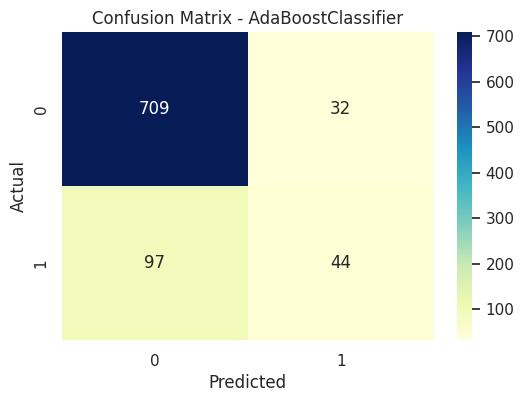

-------------------- Gradient Boosting Classifier --------------------
GradientBoostingClassifier Accuracy: 0.889

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       741
           1       0.89      0.35      0.50       141

    accuracy                           0.89       882
   macro avg       0.89      0.67      0.72       882
weighted avg       0.89      0.89      0.87       882


Confusion Matrix:
[[735   6]
 [ 92  49]]


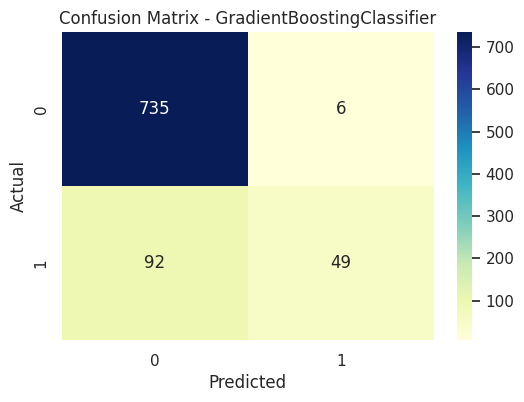

-------------------- Bagging Classifier --------------------
BaggingClassifier Accuracy: 0.988

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       741
           1       0.98      0.94      0.96       141

    accuracy                           0.99       882
   macro avg       0.98      0.97      0.98       882
weighted avg       0.99      0.99      0.99       882


Confusion Matrix:
[[738   3]
 [  8 133]]


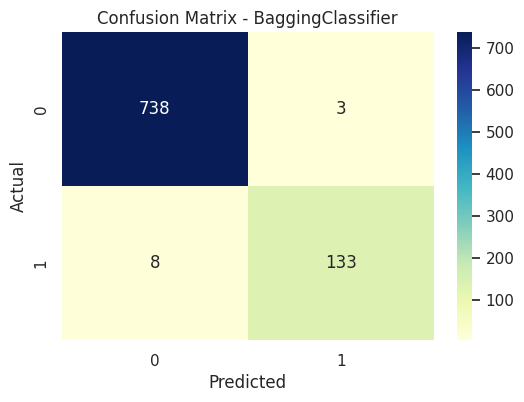

-------------------- Histogram-based Gradient Boosting Classifier --------------------
HistGradientBoostingClassifier Accuracy: 0.993

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       741
           1       1.00      0.96      0.98       141

    accuracy                           0.99       882
   macro avg       1.00      0.98      0.99       882
weighted avg       0.99      0.99      0.99       882


Confusion Matrix:
[[741   0]
 [  6 135]]


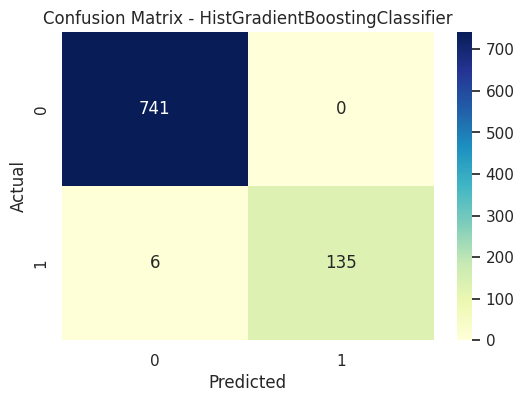

-------------------- Gaussian Naive Bayes --------------------
GaussianNB Accuracy: 0.745

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.79      0.84       741
           1       0.32      0.53      0.40       141

    accuracy                           0.74       882
   macro avg       0.61      0.66      0.62       882
weighted avg       0.81      0.74      0.77       882


Confusion Matrix:
[[582 159]
 [ 66  75]]


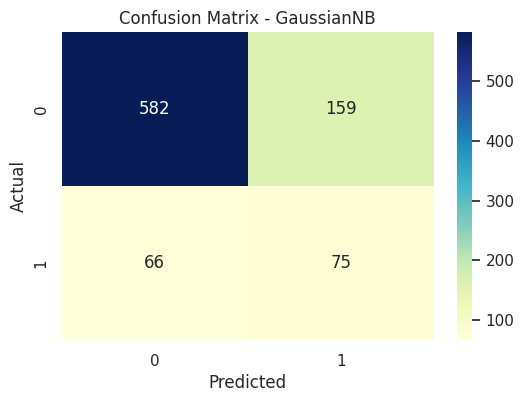

-------------------- Multi-layer Perceptron --------------------
MLPClassifier Accuracy: 0.988

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       741
           1       1.00      0.92      0.96       141

    accuracy                           0.99       882
   macro avg       0.99      0.96      0.98       882
weighted avg       0.99      0.99      0.99       882


Confusion Matrix:
[[741   0]
 [ 11 130]]


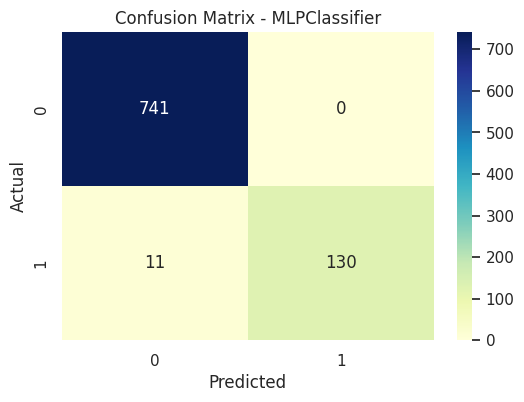

In [26]:
for classifier_name, classifier_instance in classifiers.items():
    print('-'*20, classifier_name, '-'*20)
    train_evaluate_classifier(classifier_instance, X_train, y_train, X_test, y_test)

In [27]:
# Initialize empty lists to store results
results = []

# Iterate through classifiers and evaluate each one
for classifier_name, classifier_instance in classifiers.items():
    accuracy, precision, recall, f1 = result(classifier_instance, X_train, y_train, X_test, y_test)
    results.append([classifier_name, accuracy, precision, recall, f1])

# Create a DataFrame to display the results
results_df = pd.DataFrame(results, columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

results_df.round(4)

,Classifier,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.8526,0.6279,0.1915,0.2935
1,Support Vector Classifier,0.9184,0.9481,0.5177,0.6697
2,K-Nearest Neighbors,0.8311,0.4535,0.2766,0.3436
3,Decision Tree,0.9898,0.9583,0.9787,0.9684
4,Random Forest Classifier,0.9921,1.0000,0.9504,0.9745
5,XGBoost Classifier,0.9932,0.9787,0.9787,0.9787
6,Extra Trees Classifier,0.9932,1.0000,0.9574,0.9783
7,AdaBoost Classifier,0.8537,0.5789,0.3121,0.4055
8,Gradient Boosting Classifier,0.8889,0.8909,0.3475,0.5000
9,Bagging Classifier,0.9887,1.0000,0.9291,0.9632


<a id="11"></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#82A0D8;font-family:newtimeroman;color:white;font-size:160%;text-align:center;border-radius:10px 10px;">Best Model Selection</p>

<div style="border-radius:10px; border:#8EACCD solid; padding: 15px; background-color: #D2E0FB; font-size:100%; text-align:left">
    <h3 align="left"><font color='#A367B1'>💡 Best Models Comparison</font></h3>
    <p style="color: #365486;"><b>Random Forest Classifier</b>, <b>Extra Trees Classifier</b> and <b>XGBoost Classifier</b> all demonstrate exceptional performance across multiple metrics:</p>
    <table style="color: #365486;">
      <tr>
        <th>Classifier</th>
        <th>Accuracy</th>
        <th>Precision</th>
        <th>Recall</th>
        <th>F1 Score</th>
      </tr>
      <tr>
        <td>Random Forest Classifier</td>
        <td>99.21%</td>
        <td>100.00%</td>
        <td>95.04%</td>
        <td>97.45%</td>
      </tr>
      <tr>
        <td>Extra Trees Classifier</td>
        <td>99.32%</td>
        <td>100.00%</td>
        <td>95.74%</td>
        <td>97.83%</td>
      </tr>
      <tr>
        <td>XGBoost Classifier</td>
        <td>99.32%</td>
        <td>97.87%</td>
        <td>97.87%</td>
        <td>97.87%</td>      
      </tr>
    </table>
    <p style="color: #365486;">All three models achieve accuracy above 99%, indicating their effectiveness in classifying attrition cases. However, the <b><i>Extra Trees Classifier</i></b> and <b><i>Random Forest Classifier</i></b> achieve <b><i>perfect precision</i></b>, suggesting that they <u>do not misclassify any actual attrition cases as non-attrition</u>. This is very imporant in our scenario where false positives are highly undesirable. XGBoost Classifier, while slightly lower in precision, matches the performance of the other two models in terms of recall and F1 Score.</p>

  <p style="color: #365486;">Considering that all these models perform exceptionally well in predicting employee attrition, our choice may ultimately depend on factors such as <i><b>computational resources</b></i>, <i><b>interpretability requirements</b></i> and the <i><b>integration</b></i> in different applications. In our case, <b><u>we want to prioritize models that are simpler and easier to understand</u></b>.</p> 

  <p style="color: #365486;">For applications like ours where <b>interpretability is crucial</b>, Random Forest or Extra Trees may be more suitable choices. These models offer transparent decision-making processes that can be easily explained to stakeholders. Both models are ensemble learning methods based on decision trees and they share many similarities. However, Random Forest is often preferred over Extra Trees for several reasons.</p>

  <p style="color: #365486;">While Extra Trees can sometimes offer computational advantages and may be useful in certain scenarios, Random Forest is generally preferred due to its better overall performance, lower tendency to overfit and greater interpretability.</p>

  <p style="color: #365486;"><b>Best Model</b>: considering the rationale presented, we are proceeding with the <b>Random Forest classifier model</b>.</p>
</div>

<a id="12"></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#82A0D8;font-family:newtimeroman;color:white;font-size:160%;text-align:center;border-radius:10px 10px;">Feature Importances Analysis</p>

In [28]:
def plot_feature_importances(model, feature_names, model_name):
    """
    Plot the feature importances of a machine learning model.

    Parameters:
    - model: The trained machine learning model from which feature importances will be extracted.
    - feature_names: A list containing the names of the features used in the model.
    - model_name: A string representing the name of the machine learning model.

    Returns:
    - None

    This function calculates and visualizes the importance of each feature in the provided model.
    It computes the percentage of importance for each feature relative to the total importance of all features,
    and then creates a bar plot showing the features ranked by their importance.

    Example usage:
    plot_feature_importances(rf_model, X.columns, 'Random Forest')

    """
    # Extract feature importances from the model
    feature_importances = model.feature_importances_
    
    # Calculate the total importance of all features
    total_importance = np.sum(feature_importances)
    
    # Sort feature importances in descending order
    sorted_indices = np.argsort(feature_importances)[::-1]
    
    # Reorder feature names and importances based on sorted indices
    sorted_feature_names = [feature_names[i] for i in sorted_indices]
    sorted_feature_importances = feature_importances[sorted_indices]
    
    # Calculate the percentage of importance for each feature
    sorted_feature_percentages = (sorted_feature_importances / total_importance) * 1000

    # Create a bar plot to visualize feature importances
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=sorted_feature_percentages, y=sorted_feature_names, palette="mako")
    
    # Adding percentages to each bar
    for i, v in enumerate(sorted_feature_percentages):
        ax.text(v + 0.08, i, f'{v:.2f}%', ha='left', va='center', fontsize=8, color='#056c75')
        
    # Set x-axis tick labels color and font size
    ax.tick_params(axis='y', colors='#056c75', labelsize=8)
    ax.tick_params(axis='x', colors='grey', labelsize=8)
    
    # Set plot labels and title
    ax.set_xlabel('Percentage of Importance', fontsize=10, color='grey')
    ax.set_ylabel('Feature', fontsize=10, color='grey')
    ax.set_title(f'Features Importance - {model_name}', fontsize=14, color='#660575')

    
    # Show the plot
    plt.show()


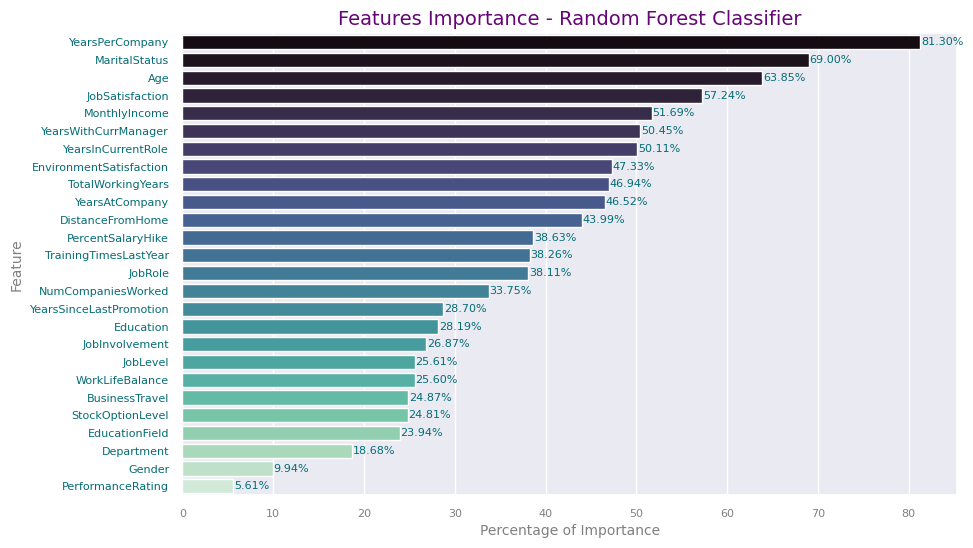

In [29]:
features = df.columns.tolist()
features.remove('Attrition')

models = {
    "Random Forest Classifier": RandomForestClassifier(),
    # "Extra Trees Classifier": ExtraTreesClassifier(),
}

for clf_name, clf in models.items():
    model = clf.fit(X_resampled, y_resampled)
    plot_feature_importances(model, features, clf_name)

<div style="border-radius:10px; border:#8EACCD solid; padding: 15px; background-color: #D2E0FB; font-size:100%; text-align:left">
    <h3 align="left"><font color='#A367B1'>💡 Features Importance Interpretations</font></h3>
    <ol style="color: #365486;">
        <li>
            <b>YearsPerCompany:</b> This feature has the highest importance in the model. Employees with fewer years per company are more likely to leave.
        </li>
        <br>
        <li>
            <b>MaritalStatus:</b> Although not directly correlated with attrition in the correlation matrix, marital status ranks high in feature importance. It could be indicative of potential life changes affecting attrition. 
        </li>
        <br>
        <li>
            <b>Age:</b> Younger employees are more likely to leave, which aligns with both the feature importance and correlation insights.
        </li>
        <br>
        <li>
            <b>JobSatisfaction:</b> Job satisfaction is a significant predictor of attrition, as indicated by both the feature importance and correlation analysis. 
        </li>
        <br>
        <li>
            <b>TotalWorkingYears:</b> Employees with longer total working years are less likely to leave the company. This underscores the importance of retaining experienced talent by offering growth opportunities and recognizing their contributions.
        </li>
        <br>
        <li>
            <b>YearsInCurrentRole:</b> Employees with shorter tenures in their current roles are more likely to leave, consistent with the correlation findings. 
        </li>
        <br>
        <li>
            <b>MonthlyIncome:</b> Although not strongly correlated, lower monthly income ranks high in feature importance. 
        </li>
        <br>
        <li>
            <b>YearsAtCompany:</b>  Similar to YearsPerCompany, shorter tenures at the company increase the likelihood of attrition. 
        </li>
        <br>
        <li>
            <b>TotalWorkingYears:</b> This feature reflects the overall work experience of employees and its impact on attrition.
        </li>
    </ol>
</div>



<div style="border-radius:10px; border:#8EACCD solid; padding: 15px; background-color: #D2E0FB; font-size:100%; text-align:left">
    <h3 align="left"><font color='#A367B1'>💡 Features Importance Recommendations</font></h3>
    <ul style="color: #365486;">
        <li>
            Implement retention strategies focused on increasing employee tenure, such as career development programs and opportunities for advancement within the company.
        </li>
        <br>
        <li>
            Conduct further qualitative research or surveys to understand the impact of marital status on employee turnover and tailor retention initiatives accordingly.
        </li>
        <br>
        <li>
            Offer mentorship programs, flexible work arrangements and opportunities for skill development to engage and retain younger talent.
        </li>
        <br>
        <li>
            Conduct regular employee satisfaction surveys, address feedback and implement measures to improve workplace culture, recognition and work-life balance.
        </li>
        <br>
        <li>
            Review compensation structures to ensure fairness and competitiveness in the market, considering factors like skills, experience and industry benchmarks.
        </li>
        <br>
        <li>
            Provide opportunities for internal mobility, skill development and career progression within the organization to retain talent and prevent stagnation.
        </li>
        <br>
        <li>
            Implement initiatives to improve employee engagement, such as recognition programs, career paths and opportunities for involvement in decision-making processes. 
        </li>
        <br>
        <li>
            Recognize and leverage the expertise of long-tenured employees, provide opportunities for knowledge sharing and ensure career development pathways for continued growth and retention.
        </li>
        <br>
    </ul>
</div>

